In [1]:
import scanpy as sc
import os
import numpy as np
import seaborn
import matplotlib
import pandas as pd
import sys
import scipy
import tqdm
import matplotlib.pyplot as plt

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis
# sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/')
import antipode
import antipode.antipode_model
import antipode.model_functions
import antipode.model_distributions
import antipode.model_modules
import antipode.train_utils
import antipode.plotting
sc.settings.figdir=os.path.expanduser('~/WbFigures/DevFinalAnalysis')

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42
})
plt.rc("axes.spines", top=False, right=False)



/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def binaryness(values, axis=None):
    """
    Compute a [0,1] binaryness score for array-like values in [0,1].

    For each v: d = min(v, 1-v).  Then
        score = 1 - 2 * mean(d)
    so that:
      - score == 1.0 if all v are 0 or 1
      - score == 0.0 if all v are 0.5
      - intermediate otherwise

    Parameters
    ----------
    values : array-like
        Expression values, must lie in [0,1].
    axis : int or None, optional
        Axis over which to compute the score.  If None, flattens first.

    Returns
    -------
    float or ndarray
        Binaryness score in [0,1].
    """
    arr = np.asarray(values, dtype=float)
    if ((arr < 0) | (arr > 1)).any():
        raise ValueError("All values must be between 0 and 1")
    d = np.minimum(arr, 1 - arr)
    m = np.nanmean(d, axis=axis)
    return np.clip(1 - 2 * m, 0.0, 1.0)


In [3]:
MDE_KEY='X_antipode_UMAP'
leaf_key = 'level_2'
discov_key = 'species'
layer_key = 'spliced'
model_tag   = '1.9.1.8.5_Dev_final_600clusters'


In [4]:
# adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/'+model_tag+'/p3_adata.h5ad',backed='r')
adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/'+model_tag+'/analysis_inprogress.h5ad',backed='r')

In [5]:
adata.obs.index=adata.obs.index.to_series().str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)

In [6]:
curateds=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/curated_class.txt',index_col=0)
curateds=curateds.rename({leaf_key:'anno_level_2'},axis=1)
#adata.obs.loc[:,curateds.columns]=adata.obs.loc[:,curateds.columns].astype('string')
adata.obs.loc[:,curateds.columns]=curateds.astype('string')
adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/inferred_sex.csv',index_col=0).to_dict()['female'])

/scratch/fast/1984395/ipykernel_2065147/153555327.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<StringArray>
['188', '286',  '29', '271', '178', '226',  '57', '123', '223', '267',
 ...
  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>,  <NA>]
Length: 1854767, dtype: string' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  adata.obs.loc[:,curateds.columns]=curateds.astype('string')
/scratch/fast/1984395/ipykernel_2065147/153555327.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/inferred_sex.csv',index_col=0).to_dict()['fe

# LaManno Labels

In [7]:
linnarson_labels=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/mousefastqpool/SRP135960_linnarson_adultmouse/annotations/unambiguous_metadata_renamed.csv',index_col=0)

In [8]:
linnarson_labels.index = list(linnarson_labels.index.to_series().str.replace('-[0-9]+$','',regex=True))

In [9]:
linnarson_labels=linnarson_labels.loc[linnarson_labels.index.isin(adata.obs.index),:]

In [10]:
list(linnarson_labels['Subclass'].value_counts().index)

['Cortical or hippocampal glutamatergic',
 'Forebrain GABAergic',
 'Midbrain glutamatergic',
 'Forebrain glutamatergic',
 'Forebrain',
 'Dorsal forebrain',
 'Hindbrain',
 'Neuronal intermediate progenitor',
 'Hindbrain glycinergic',
 'Hindbrain glutamatergic',
 'Mesenchyme',
 'Midbrain GABAergic',
 'Midbrain',
 'Mixed region',
 'Mixed region GABAergic',
 'Endothelial',
 'Undefined',
 'Mixed region glutamatergic',
 'Hypothalamus',
 'Hindbrain GABAergic',
 'Mixed region and neurotransmitter',
 'Mixed region astrocytes',
 'Dorsal hindbrain',
 'Cerebellum glutamatergic',
 'Early fibroblasts',
 'Oligodendrocyte precursor cell',
 'Dorsal midbrain',
 'Cajal-Retzius',
 'Pia 2',
 'Pericyte',
 'Cortical hem',
 'Epithalamus glutamatergic',
 'Non-cycling perivascular macrophages',
 'Midbrain-hindbrain boundary',
 'Hindbrain roof plate',
 'Intermediate meninges 1',
 'Ventral midbrain',
 'Angioblast',
 'Sensory neuron',
 'Nascent mesoderm',
 'Spinal cord glutamatergic',
 'Caudal',
 'PreOPC',
 'Pia 3

In [11]:
cols=dict(zip(["Class","Subclass","ClusterName"],["lamanno_class","lamanno_subclass","lamanno_cluster"]))#linnarson_labels.columns[~linnarson_labels.columns.isin(adata.obs.columns)]
for k,v in cols.items():
    try:
        adata.obs.drop(v,axis=1,inplace=True)
        print('dropped')
        adata.obs[v] = 'nan'
        adata.obs[k] = 'nan'
    except:
        pass
adata.obs.loc[linnarson_labels.index,cols.keys()]=linnarson_labels.loc[:,cols.keys()]
adata.obs.rename(columns=cols,inplace=True)

dropped
dropped
dropped


In [12]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["lamanno_class","lamanno_subclass","lamanno_cluster"],
#     palette=sc.pl.palettes.godsnot_102
# )


In [13]:
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]

In [14]:
adata.obs['lamanno_subclass'].value_counts()

lamanno_subclass
nan                                      1635111
Cortical or hippocampal glutamatergic      21502
Forebrain GABAergic                        19796
Midbrain glutamatergic                     13276
Forebrain glutamatergic                    11603
                                          ...   
Olfactory epithelium                          10
Parietal endoderm                             10
Schwann cell                                   4
Olfactory ensheathing cell                     1
Extraembryonic ectoderm                        1
Name: count, Length: 134, dtype: int64

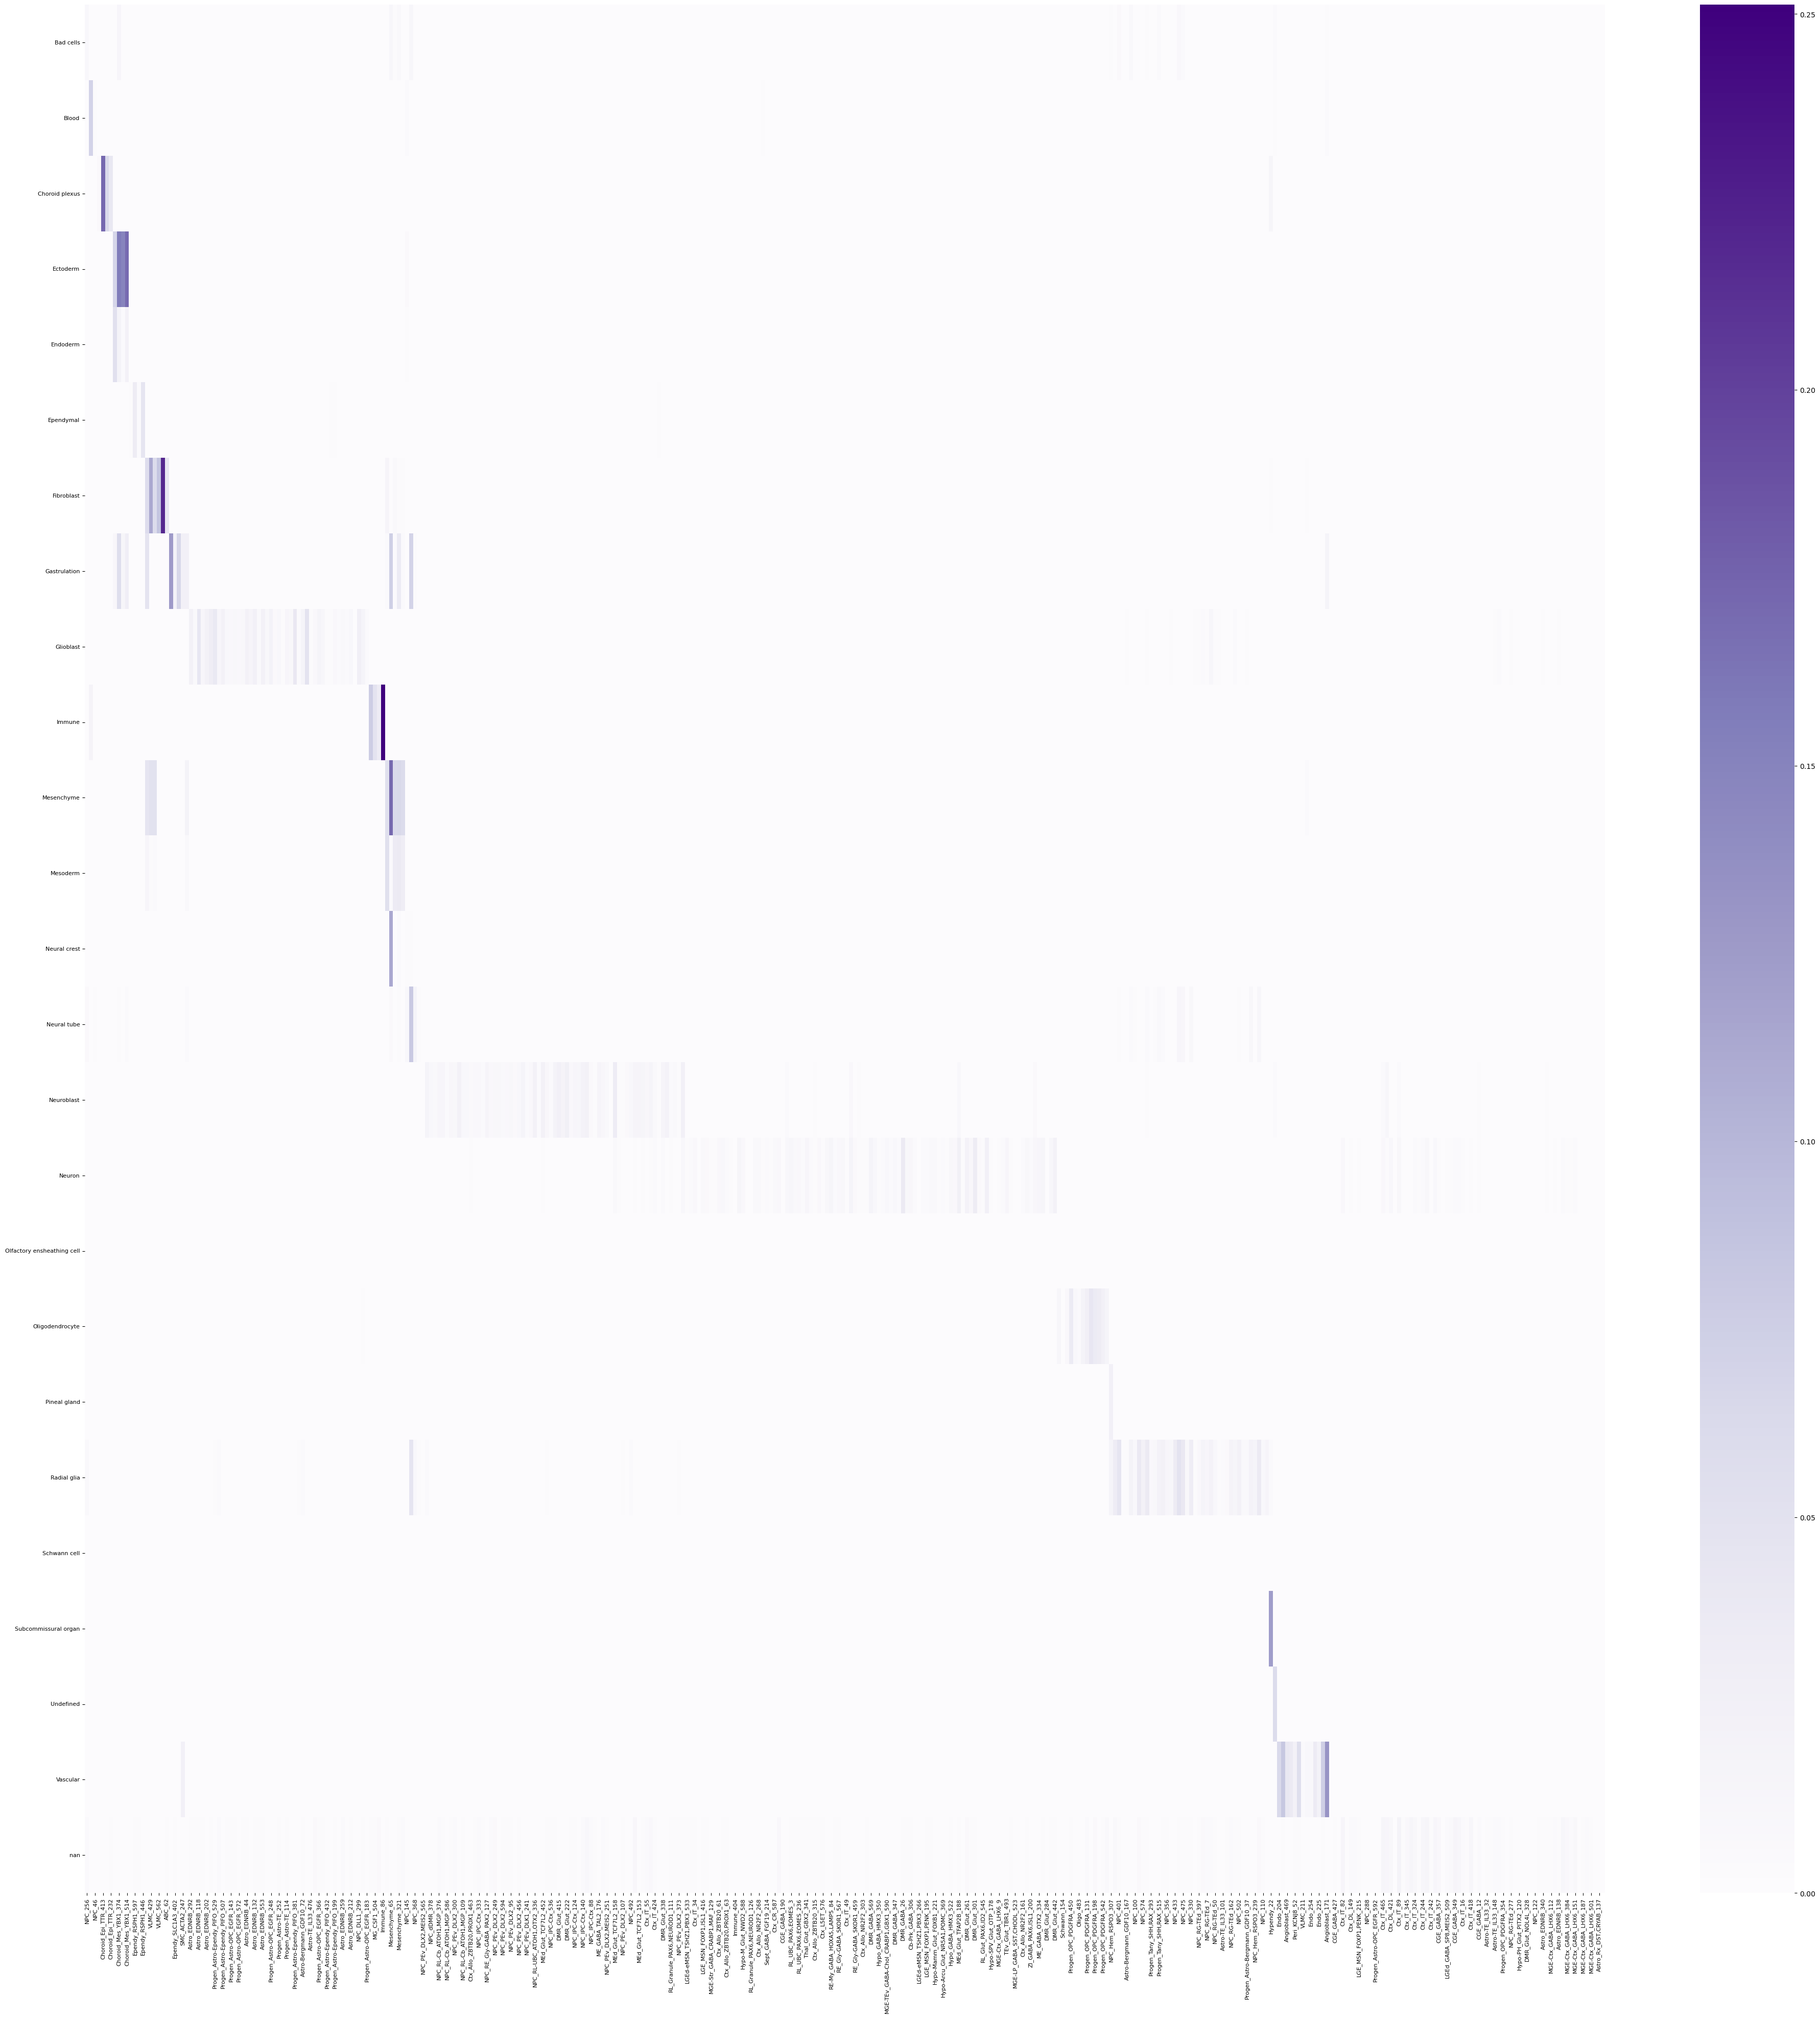

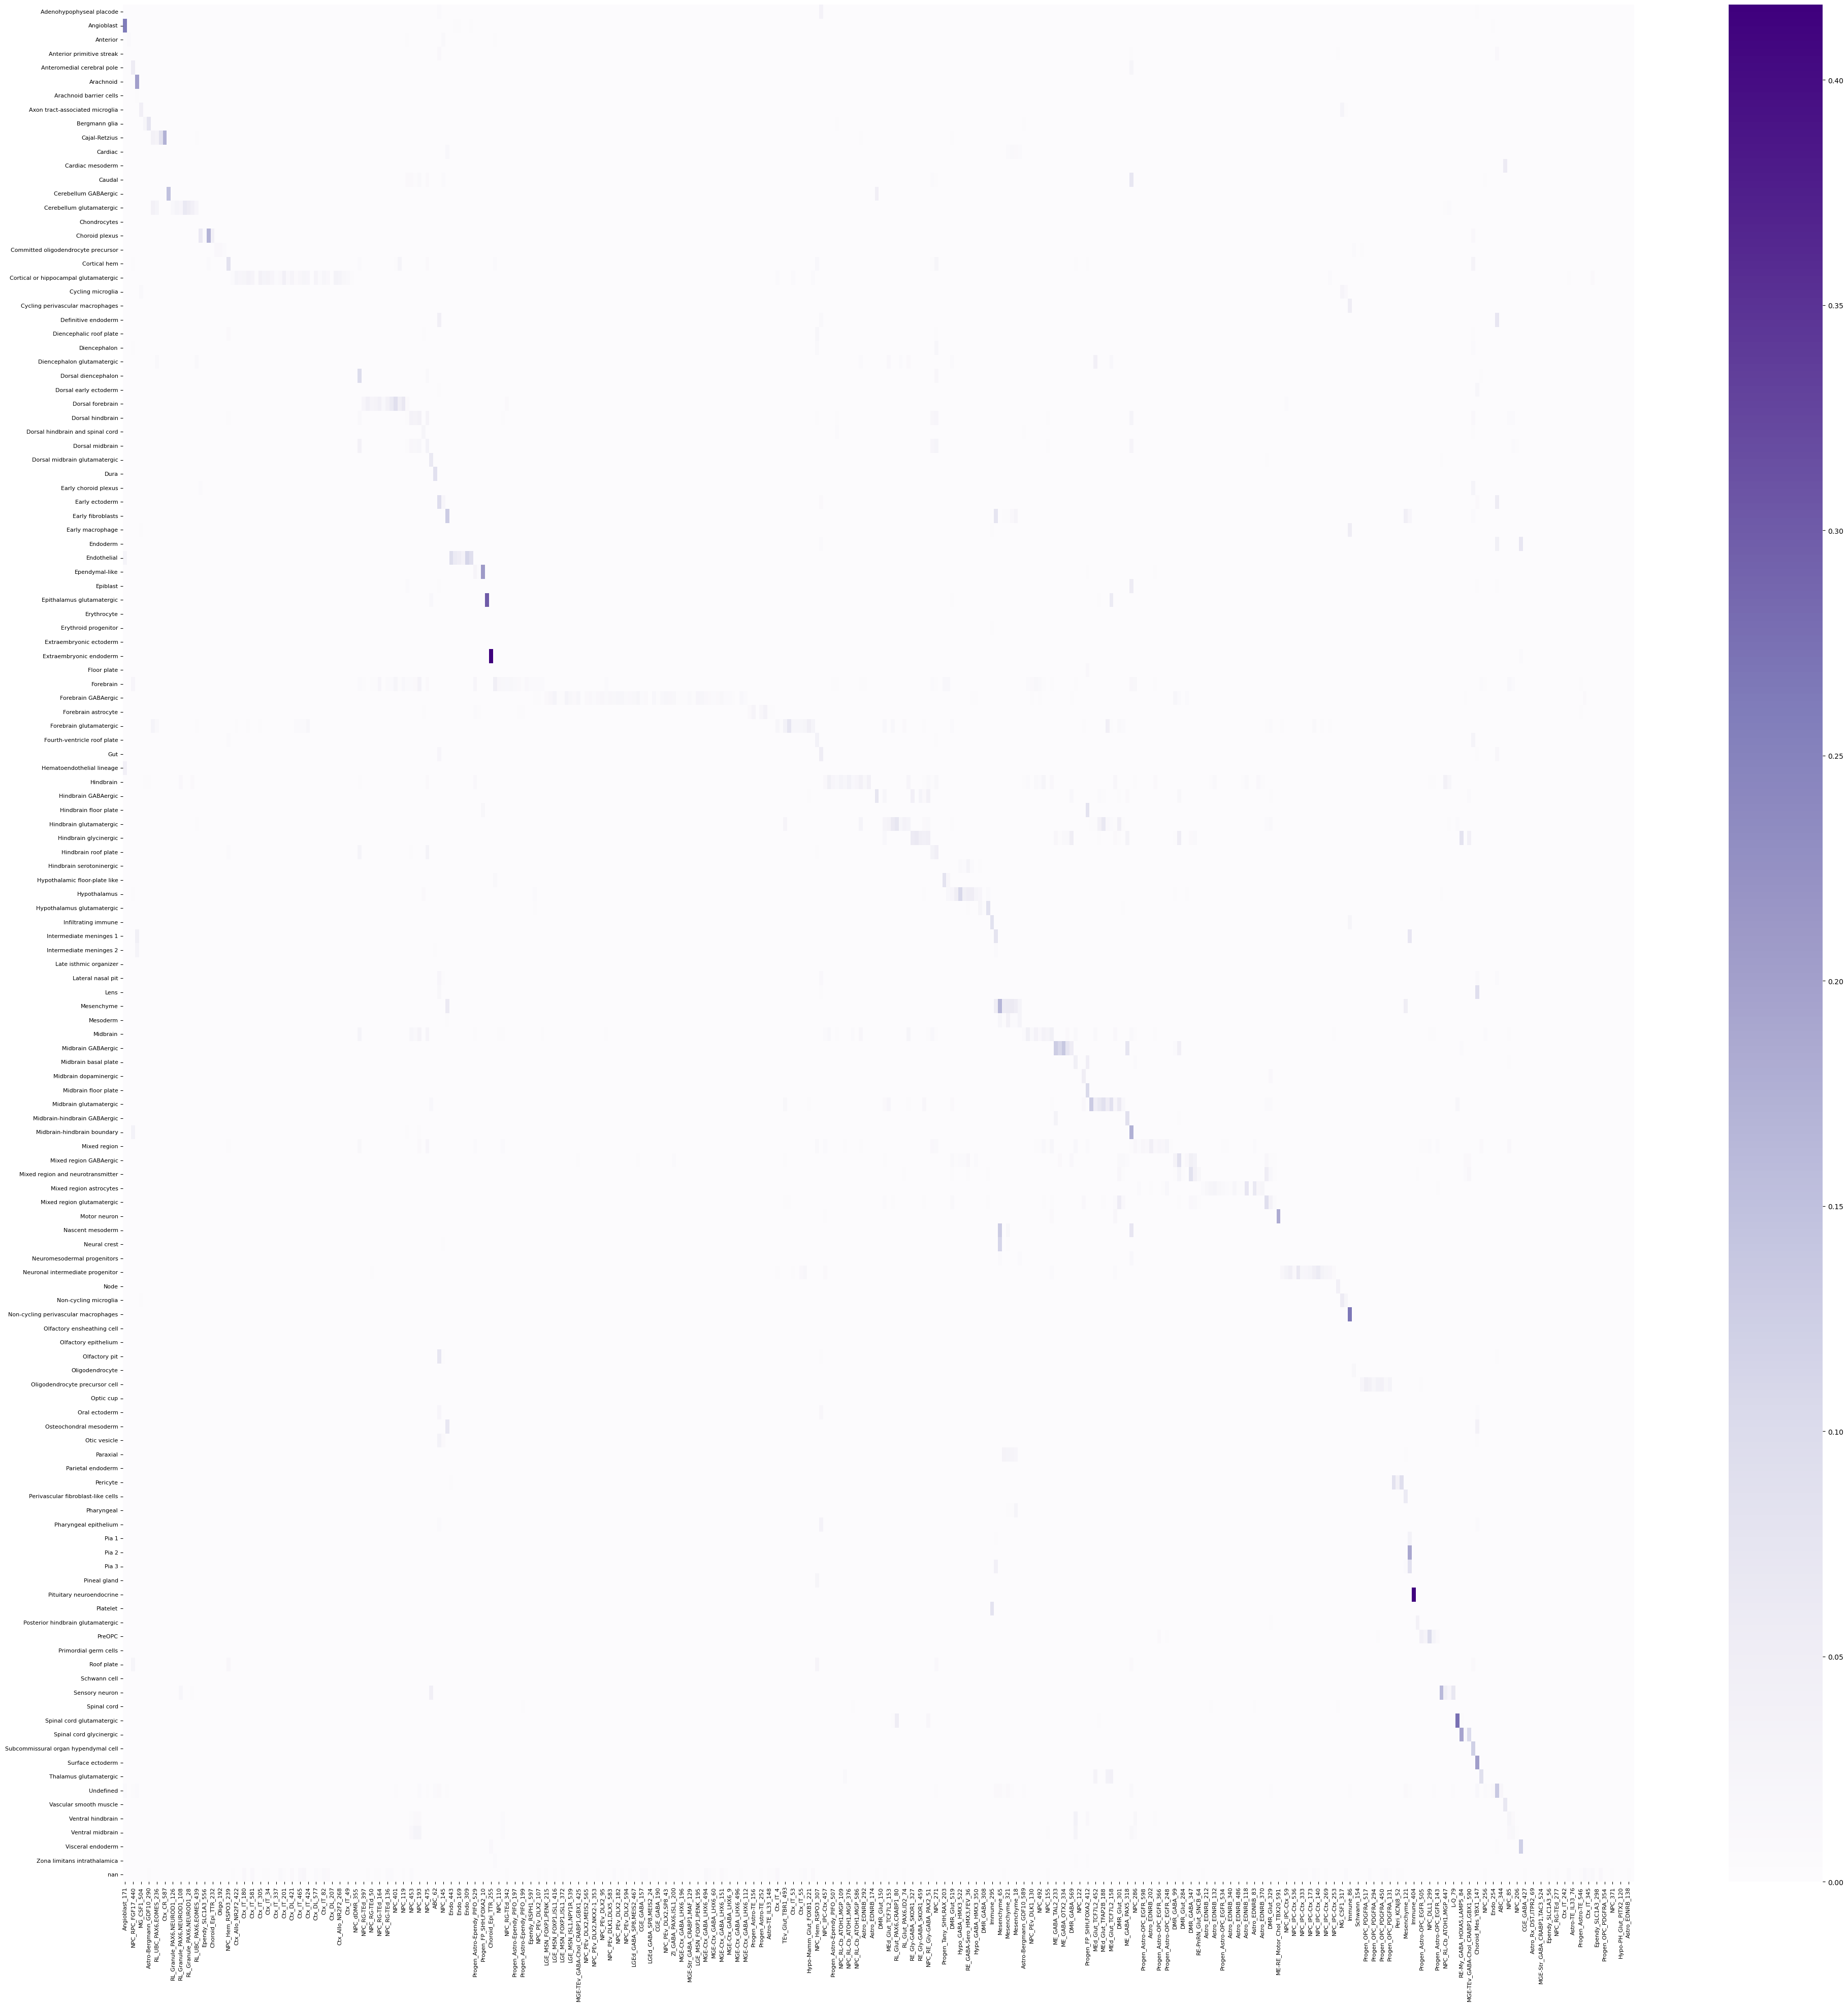

In [15]:
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_class','Initial_Class_markers_level_2'),cmap='Purples')
plt.show()
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_subclass','Initial_Class_markers_level_2'),cmap='Purples')
plt.savefig(os.path.join(sc.settings.figdir,'lamanno_subclass_jaccard.svg'))
plt.show()
# sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'Initial_Class_markers_level_2','lamanno_cluster'),cmap='Purples')

In [16]:
xcj=sc_analysis.get_cross_category_jaccard(adata.obs,'lamanno_subclass',leaf_key)

In [17]:
adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())

/scratch/fast/1984395/ipykernel_2065147/2888605536.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/1984395/ipykernel_2065147/2888605536.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['linnarson_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['lamanno_subclass'].value_counts().unstack().idxmax(1).to_dict())


In [18]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended",leaf_key],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )

# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["linnarson_extended"],
#     palette=sc.pl.palettes.godsnot_102
# )


In [19]:
in_obs=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/annotations/GSE169122_obs.csv.gz',index_col=0)
inds=adata.obs.index.str.replace(r'-\d+$', '', regex=True).str.replace(r'-\d+$', '', regex=True)
get_inds=inds[inds.isin(in_obs.index)]
adata.obs.loc[adata.obs.index[inds.isin(in_obs.index)],'initial_class']=list(in_obs.loc[adata.obs.index[inds.isin(in_obs.index)].str.replace(r'-\d+$', '', regex=True).str.replace(r'-\d+$', '', regex=True),'class'])
counts=adata.obs.groupby(leaf_key)['initial_class'].value_counts().unstack()
# couts = counts.drop('nan',axis=1)
counts=((10+counts.T)/((10+counts).T.sum(0))).T
counts['nan']=0.2
counts.index = counts.index.astype('str')
adata.obs['ic_extended']=adata.obs[leaf_key].replace(counts.idxmax(1).to_dict())
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]

/scratch/fast/1984395/ipykernel_2065147/2111262100.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts=adata.obs.groupby(leaf_key)['initial_class'].value_counts().unstack()


In [20]:
adata.obs['ic_extended'].value_counts()

ic_extended
89     32996
349    25112
581    24885
465    24420
180    23599
       ...  
496      325
46       155
70        96
145       43
404       17
Name: count, Length: 380, dtype: int64

In [21]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=['ic_extended'],
#     palette=sc.pl.palettes.godsnot_102,
#     legend_loc='on data'
# )

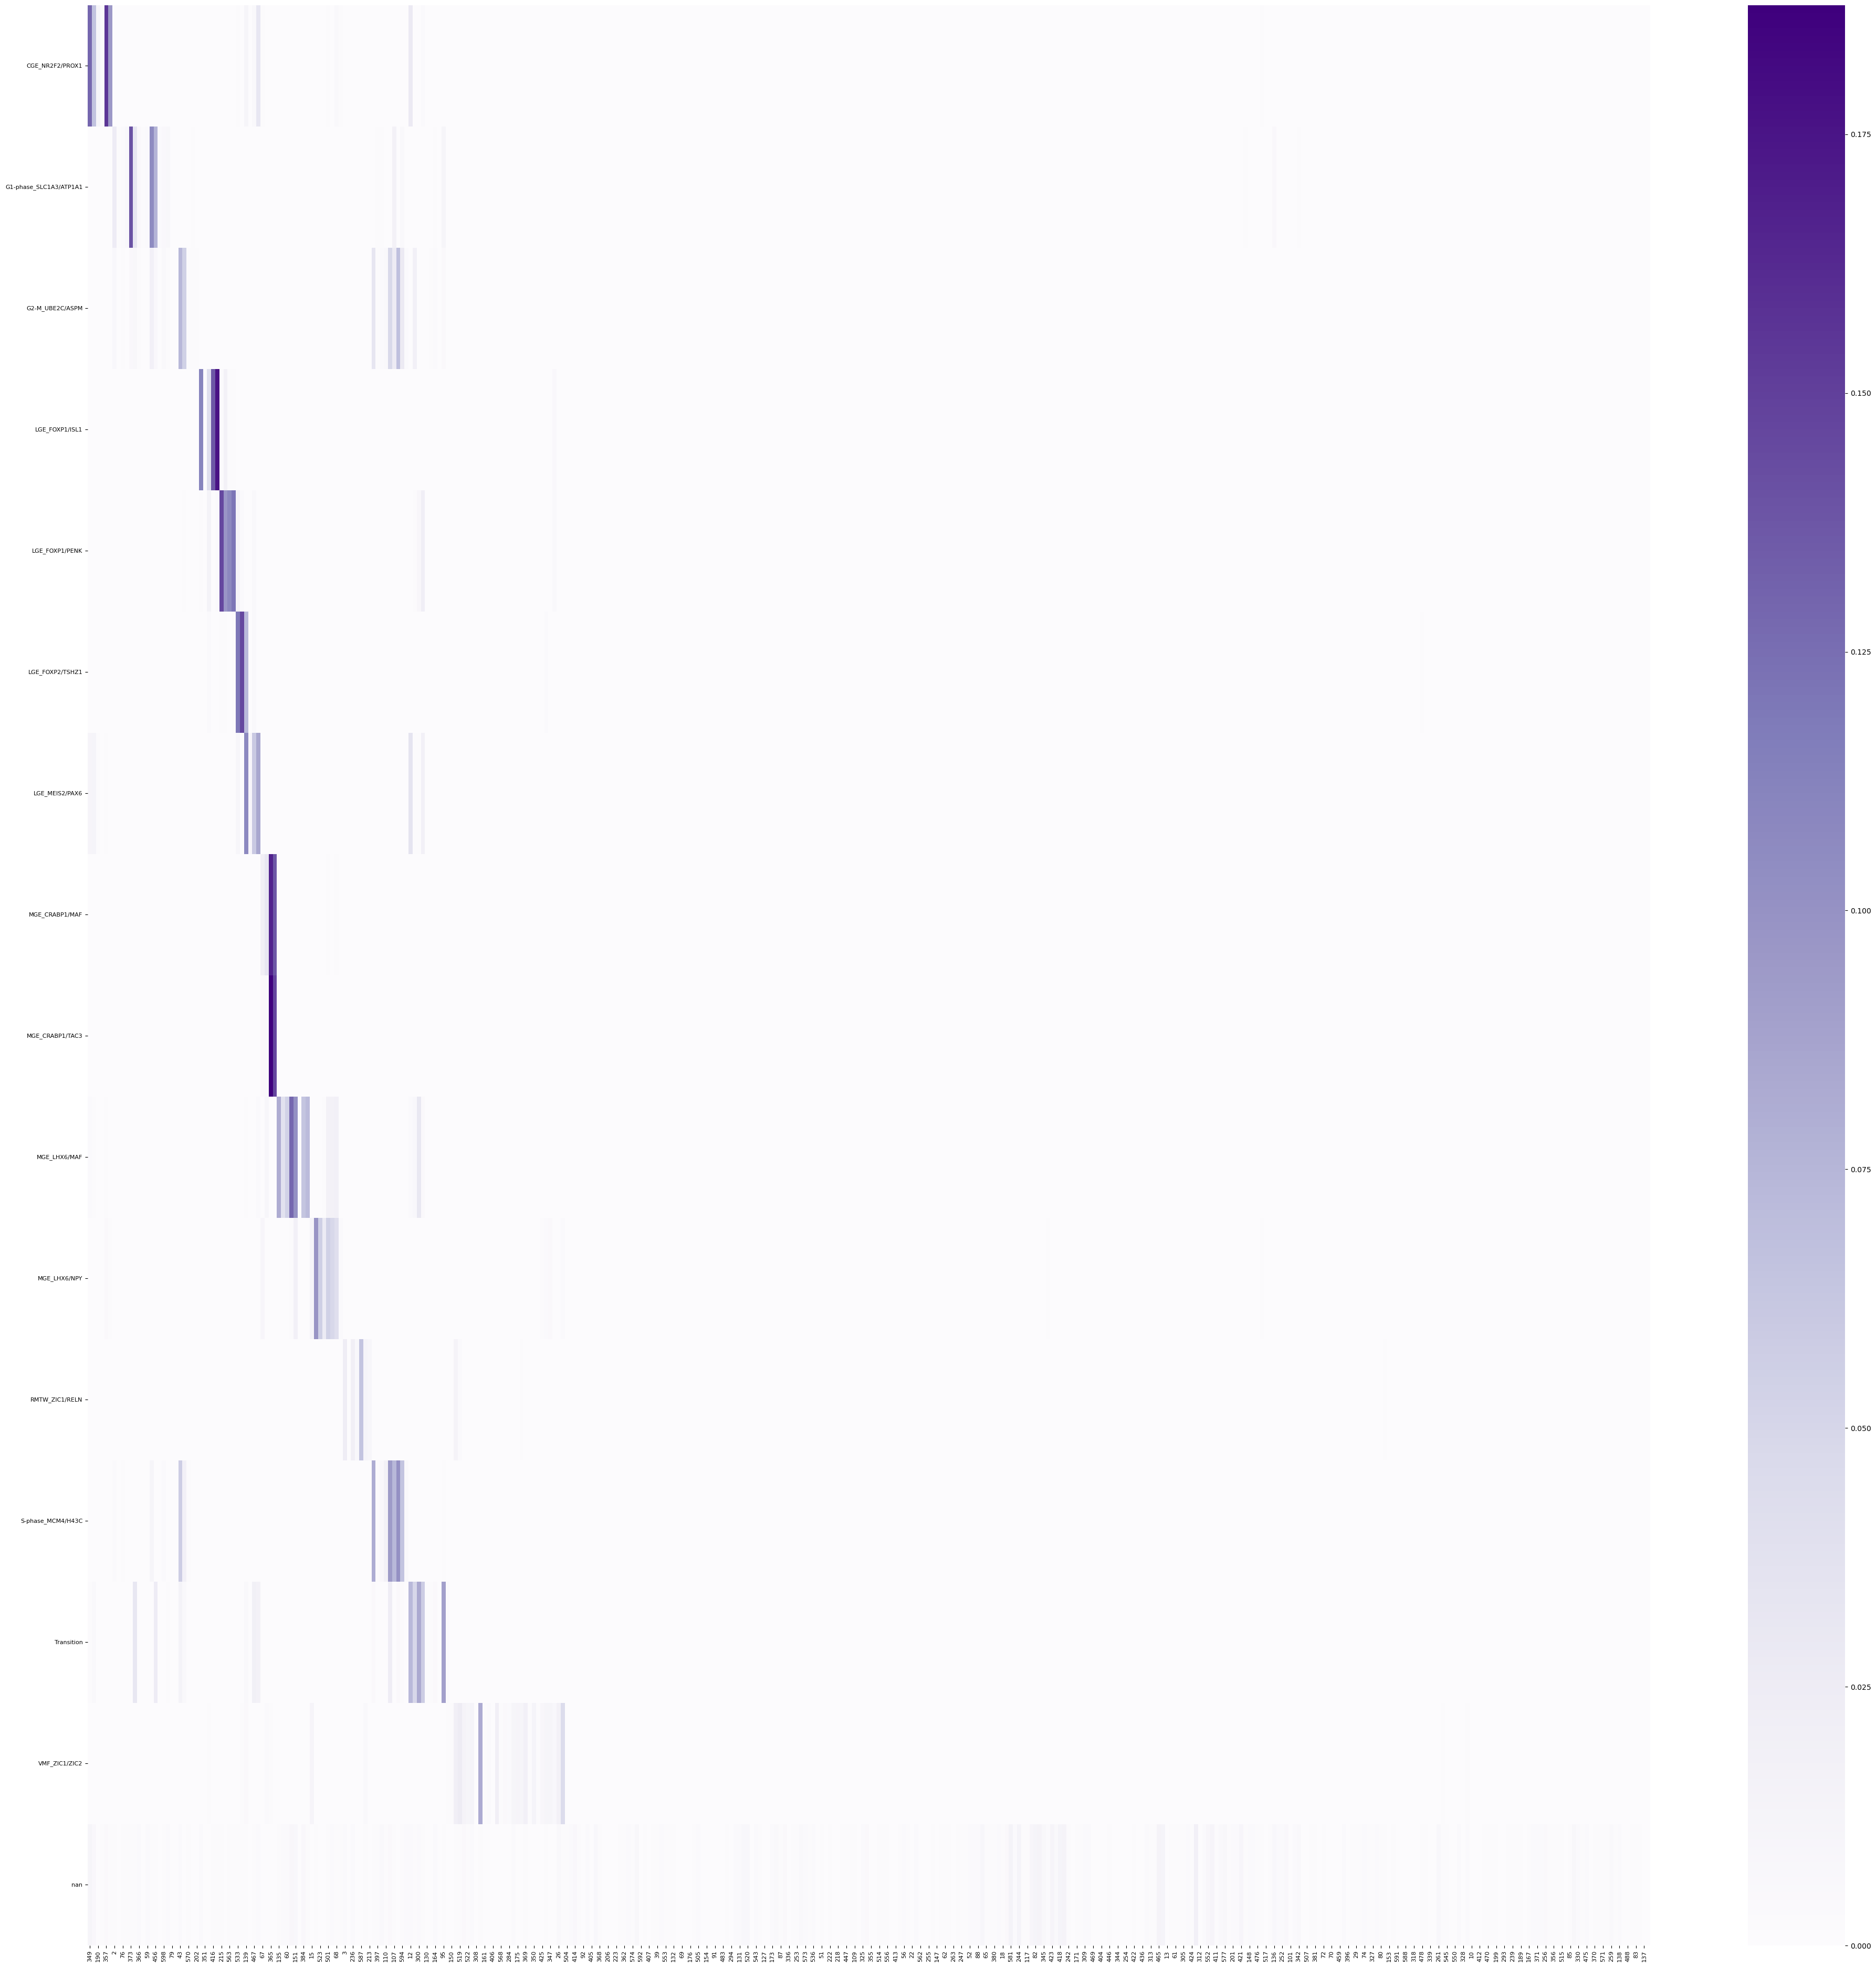

In [22]:
sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'initial_class',leaf_key),cmap='Purples')

# TF correlation

Used ABC (Yao 2023) subclasses in the dataset or with ABC mapped onto mouse juvenile (Linnarson)

In [23]:
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]

100%|██████████| 380/380 [03:03<00:00,  2.07it/s]


In [24]:
np.exp(real_means).sum(1)

304    0.582365
137    0.069620
174    0.881792
83     0.888386
320    0.857530
         ...   
187    0.899628
196    0.902076
501    0.903718
9      0.883708
523    0.890642
Length: 380, dtype: float64

In [25]:
abc_subclass_means=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/mouse_wb/AIT21.all.freeze.230815_subclassmeans.csv',index_col=0)

In [26]:
dev_mouse_means = pd.DataFrame(log_real_means[2],columns=adata.var.index,index=real_mean_levels[leaf_key])
dev_mouse_log_means = pd.DataFrame(log_real_means[2],columns=adata.var.index,index=real_mean_levels[leaf_key])
dev_mouse_means = dev_mouse_means.loc[:,dev_mouse_means.columns.isin(abc_subclass_means.columns)]
dev_mouse_log_means = dev_mouse_log_means.loc[:,dev_mouse_log_means.columns.isin(abc_subclass_means.columns)]
dev_mouse_means = np.exp(dev_mouse_means-dev_mouse_means.max(0)) #scaled linear-space pseudobulk

In [27]:
abc_subclass_means=abc_subclass_means.loc[:,abc_subclass_means.columns.isin(dev_mouse_means.columns)]
abc_subclass_means=abc_subclass_means.loc[:,sorted(abc_subclass_means.columns)]

In [28]:
abc_subclass_means = np.exp(abc_subclass_means)-1.
abc_subclass_means = abc_subclass_means + (0.5/abc_subclass_means.sum(1).to_numpy()[:,np.newaxis]) #Match pseudocounting strategy
abc_subclass_means = np.log(abc_subclass_means/abc_subclass_means.sum(1).to_numpy()[:,np.newaxis])
abc_subclass_means = np.exp(abc_subclass_means-abc_subclass_means.max(0)) #scaled linear-space pseudobulk

In [29]:
# abc_subclass_means = np.exp(abc_subclass_means-abc_subclass_means.max(0)) #scaled linear-space pseudobulk

In [30]:
dev_mouse_means.sum(1)

304    1150.214807
137      31.126498
174    2185.219448
83     2128.519399
320    2207.729395
          ...     
187    2133.253327
196    2100.995022
501    2329.207096
9      2119.747853
523    2231.728026
Length: 380, dtype: float64

In [31]:
abc_subclass_means.sum(1)

001 CLA-EPd-CTX Car3 Glut    1075.892013
002 IT EP-CLA Glut           1639.565155
003 L5/6 IT TPE-ENT Glut     1519.150356
004 L6 IT CTX Glut           1140.239906
005 L5 IT CTX Glut           1312.458060
                                ...     
334 Microglia NN              915.835097
335 BAM NN                   1042.978193
336 Monocytes NN              813.535706
337 DC NN                     940.675761
338 Lymphoid NN               699.827631
Length: 338, dtype: float64

<Axes: ylabel='Count'>

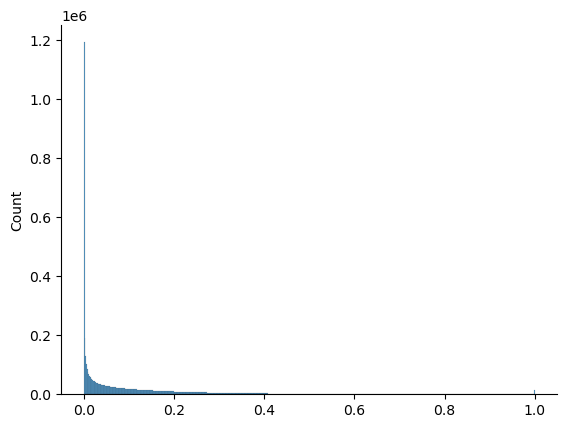

In [32]:
seaborn.histplot(abc_subclass_means.to_numpy().flatten())

<Axes: ylabel='Count'>

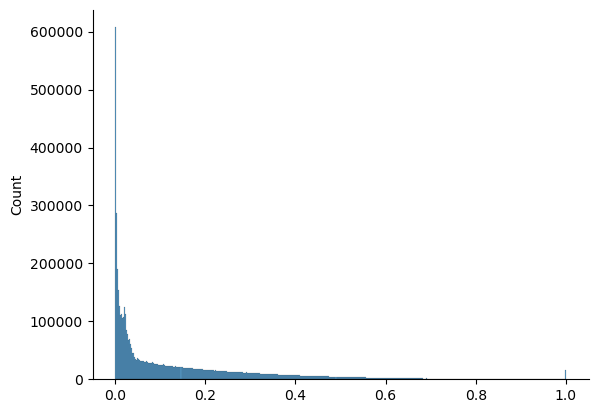

In [33]:
seaborn.histplot(dev_mouse_means.to_numpy().flatten())

In [34]:
#Remove the OB granule cells because their immaturity is a magnet for all dev cells
abc_subclass_means=abc_subclass_means.loc[~abc_subclass_means.index.str.contains('OB-STR'),:]

In [35]:
tf_genes=pd.read_csv('/home/matthew.schmitz/Matthew/utils/zizhens_tf_code.txt',sep='\t')
include_genes=tf_genes['gene'].str.upper()
include_genes = dev_mouse_means.columns[dev_mouse_means.columns.isin(include_genes)]
print(len(tf_genes))

260


In [36]:
neigh_l2 = adata.obs.loc[:,['Neighborhood','level_2','Initial_Class_markers_level_2']].drop_duplicates()
# neigh_l2 = neigh_l2.loc[~neigh_l2['Neighborhood'].isin(['Neighbor']),:]
neigh_l2.index = list(neigh_l2['level_2'].astype(int))


In [37]:
# Spearman does much worse than linear tf pearson (way more binary)
corrs=sc_analysis.corr2_coeff(dev_mouse_means.loc[:,dev_mouse_means.columns.isin(include_genes)],abc_subclass_means.loc[:,abc_subclass_means.columns.isin(include_genes)])
corrs=np.nan_to_num(corrs,0.)
plot_corrs=pd.DataFrame(corrs,index=dev_mouse_means.index,columns=abc_subclass_means.index)
plot_corrs.index = plot_corrs.index.to_series().replace(dict(zip(neigh_l2['level_2'],neigh_l2['Initial_Class_markers_level_2'])))

corrs=pd.DataFrame(corrs,index=dev_mouse_means.index,columns=abc_subclass_means.index)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


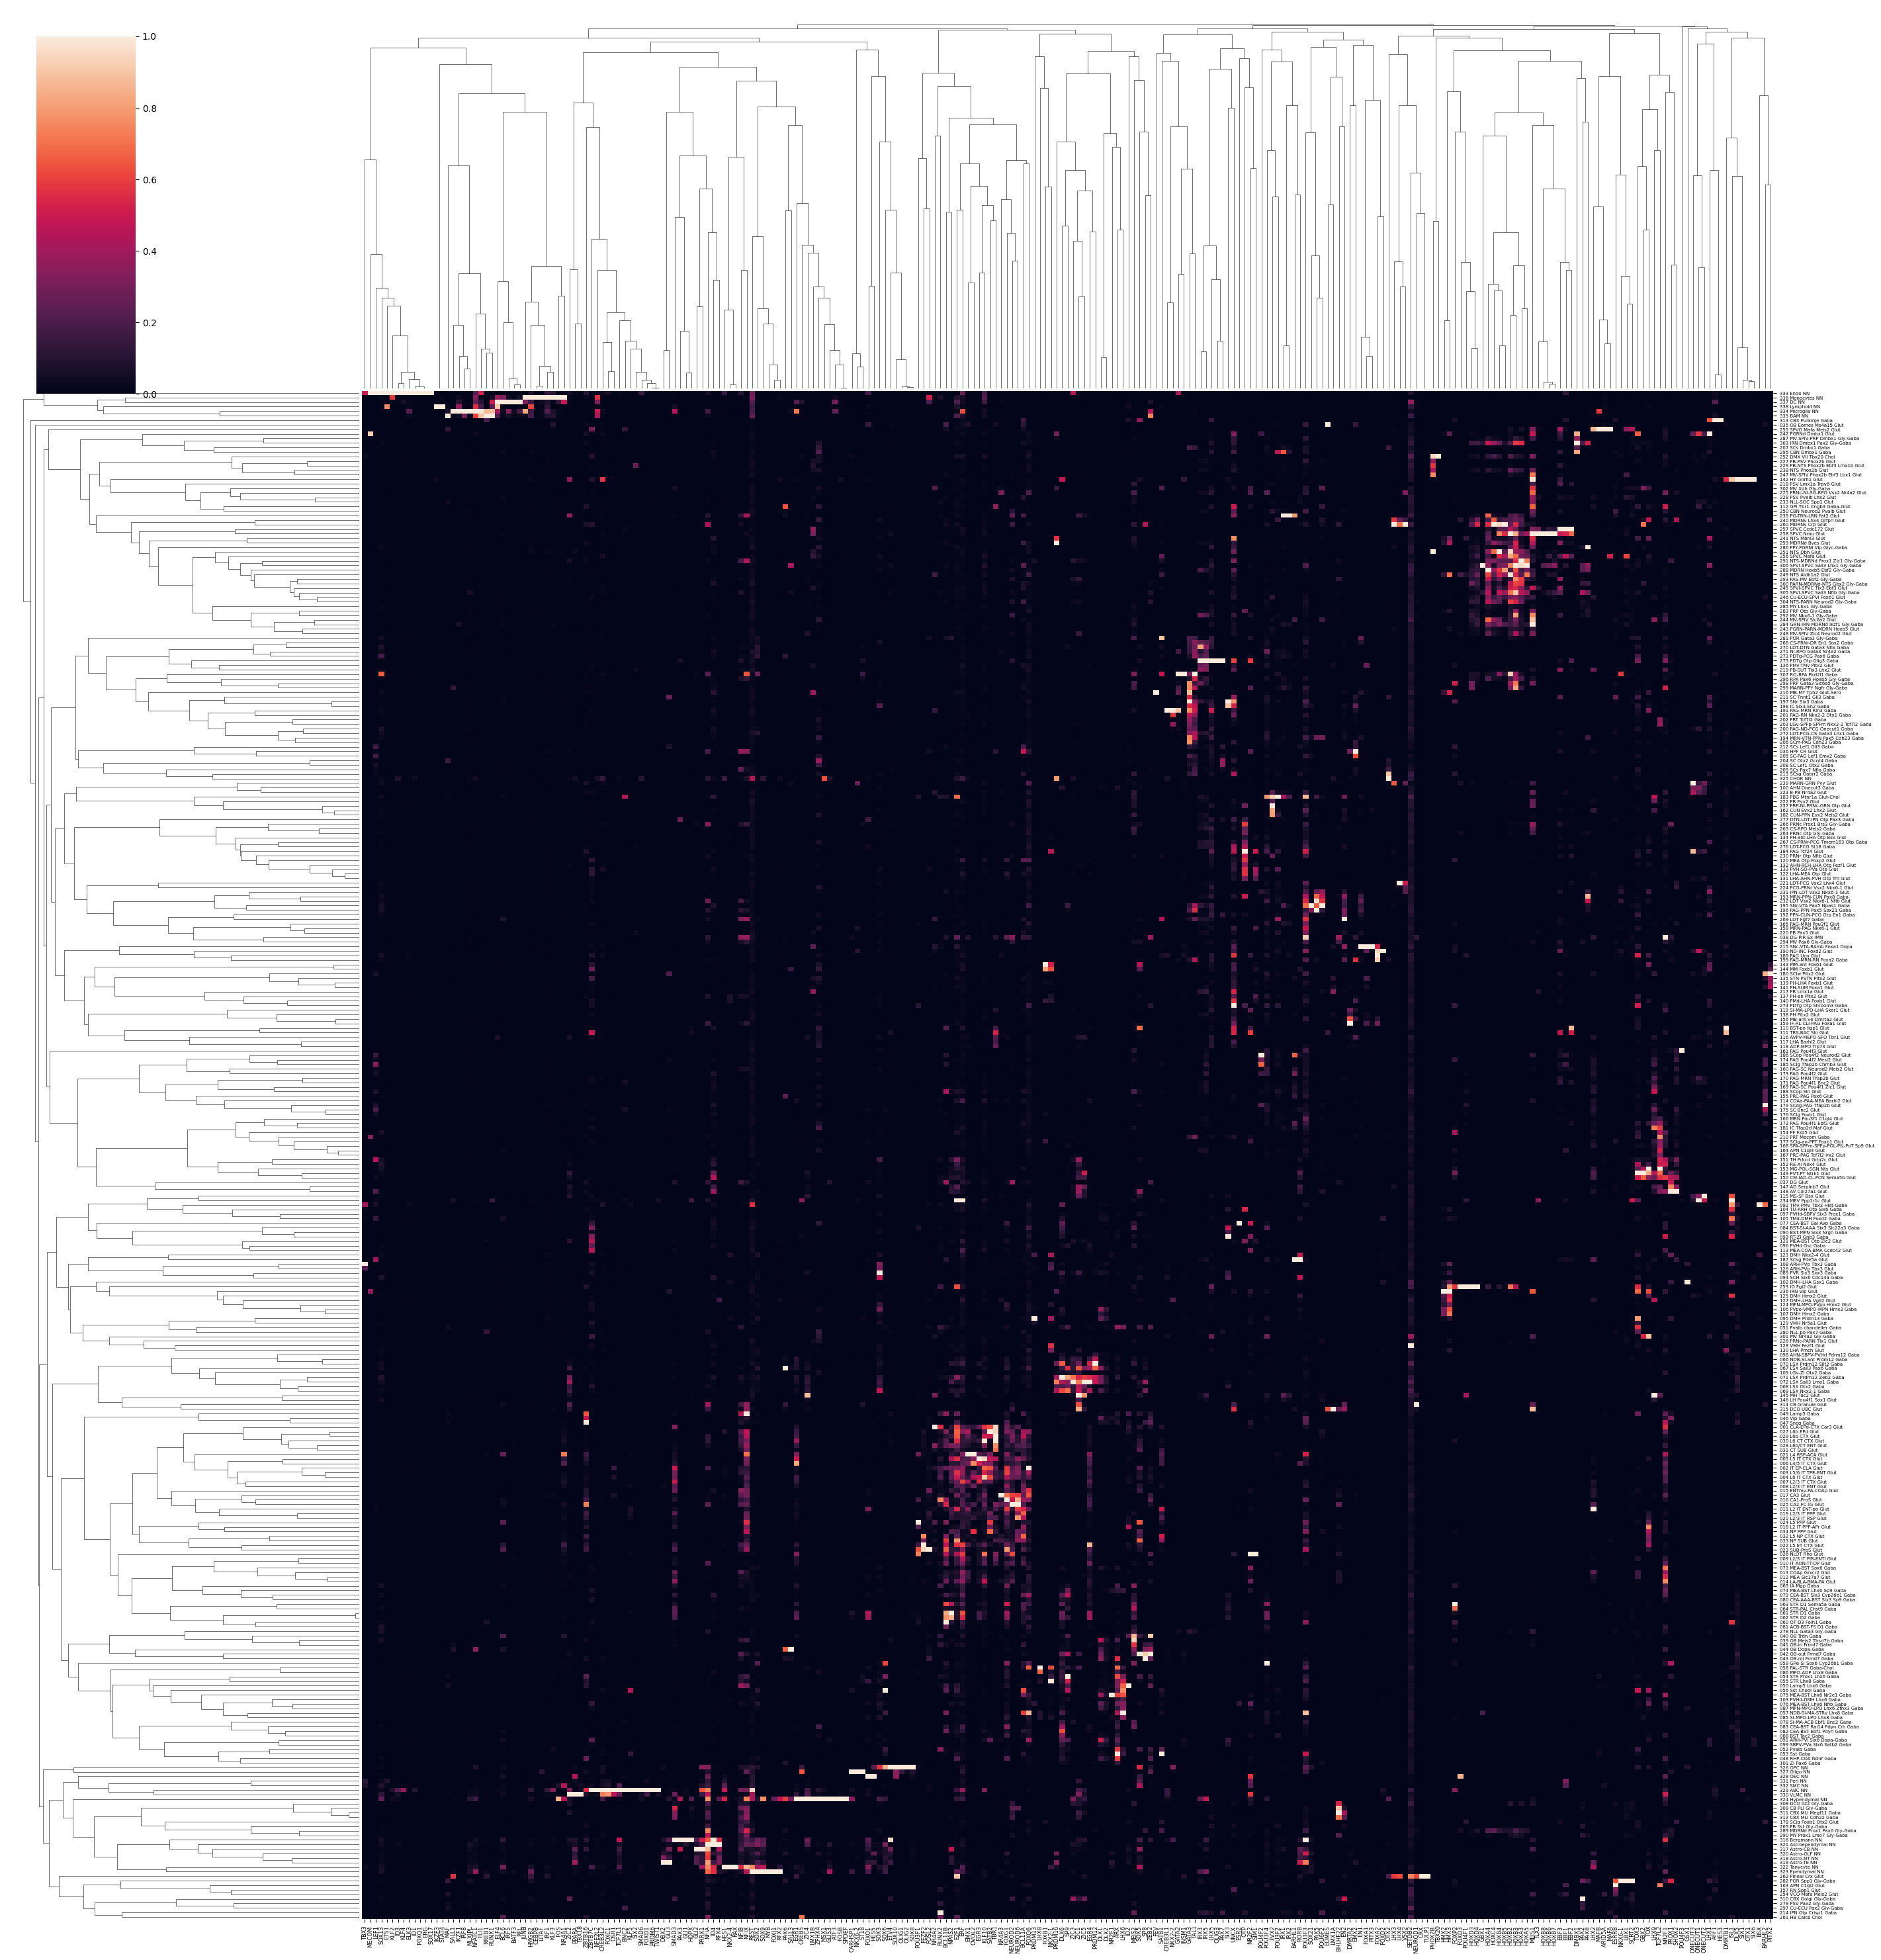

In [38]:
g=seaborn.clustermap(abc_subclass_means.loc[:,abc_subclass_means.columns.isin(include_genes)],col_cluster=True,figsize=(30,30),xticklabels=True,yticklabels=True,metric='correlation')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)
plt.savefig(os.path.join(sc.settings.figdir,'adult_mouse_adult_mouse_tf_means.png'))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


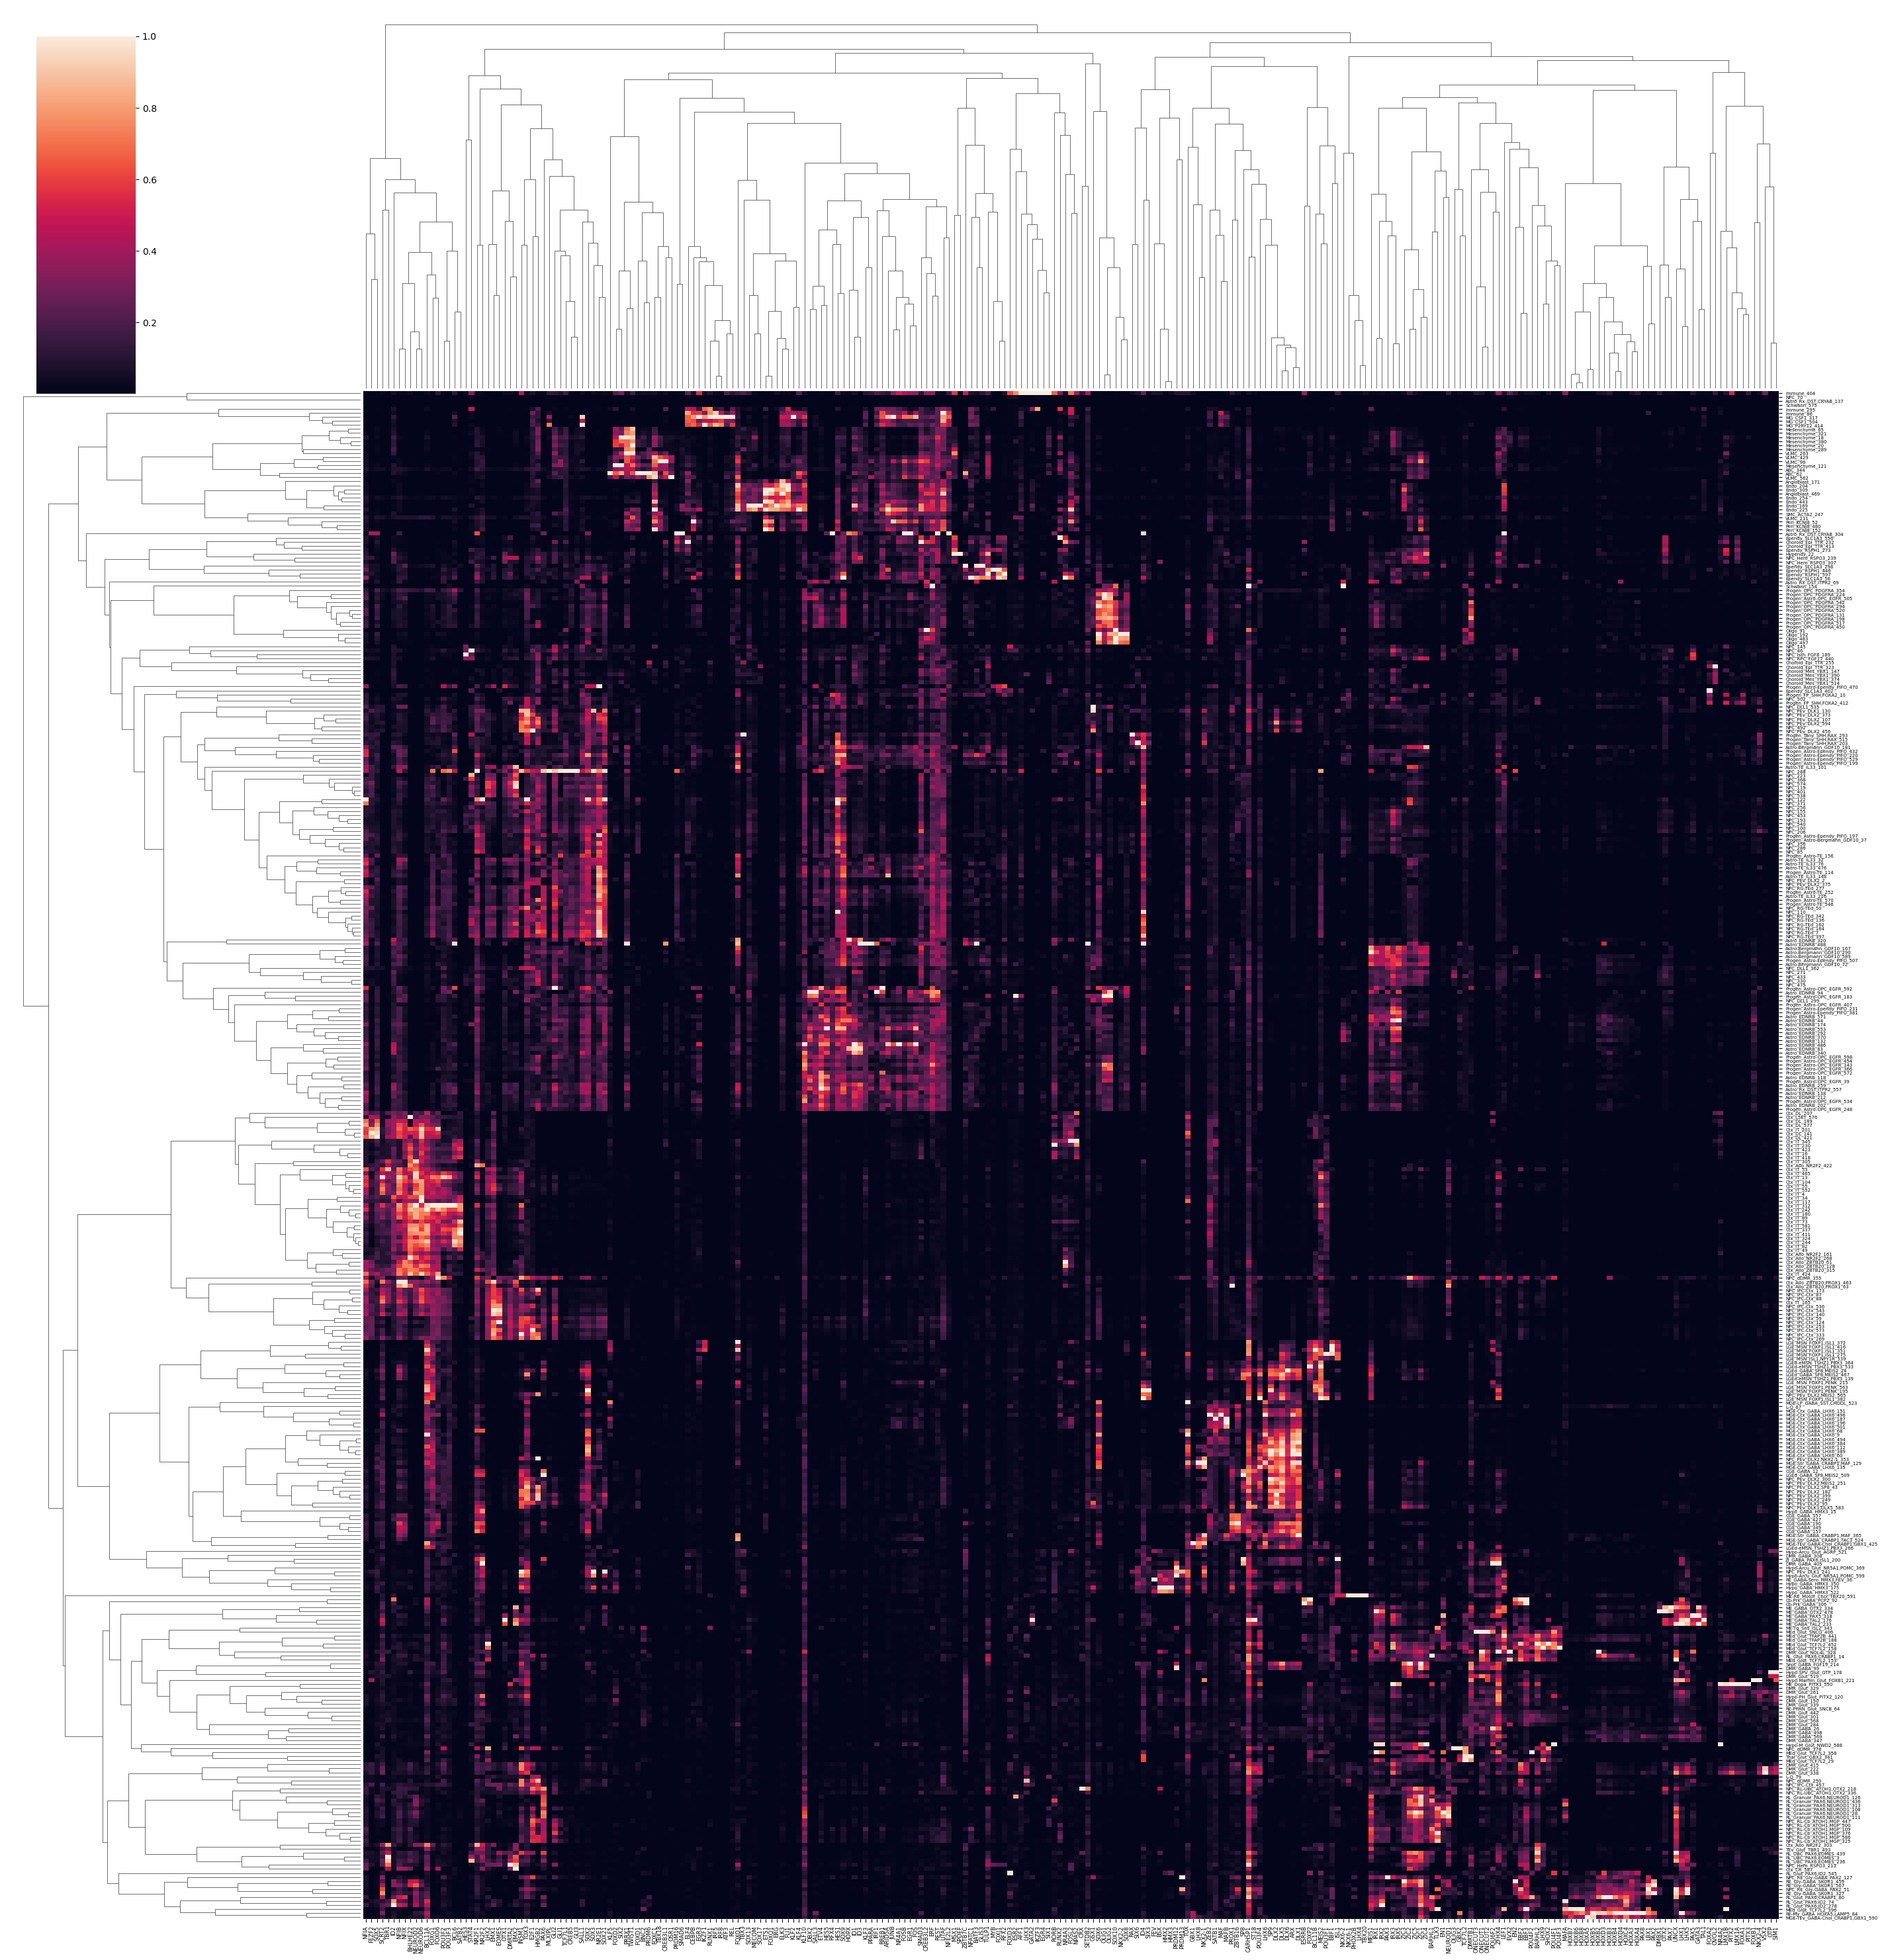

In [39]:
plot_dev_mouse_means = dev_mouse_means.copy()
plot_dev_mouse_means.index = plot_dev_mouse_means.index.to_series().replace(dict(zip(neigh_l2['level_2'],neigh_l2['Initial_Class_markers_level_2'])))
g = seaborn.clustermap(plot_dev_mouse_means.loc[:,plot_dev_mouse_means.columns.isin(include_genes)],col_cluster=True,figsize=(30,30),xticklabels=True,yticklabels=True,metric='correlation')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)
plt.savefig(os.path.join(sc.settings.figdir,'dev_mouse_adult_mouse_tf_means.png'))

Text(247.4027777777778, 0.5, 'Initial_Class_markers')

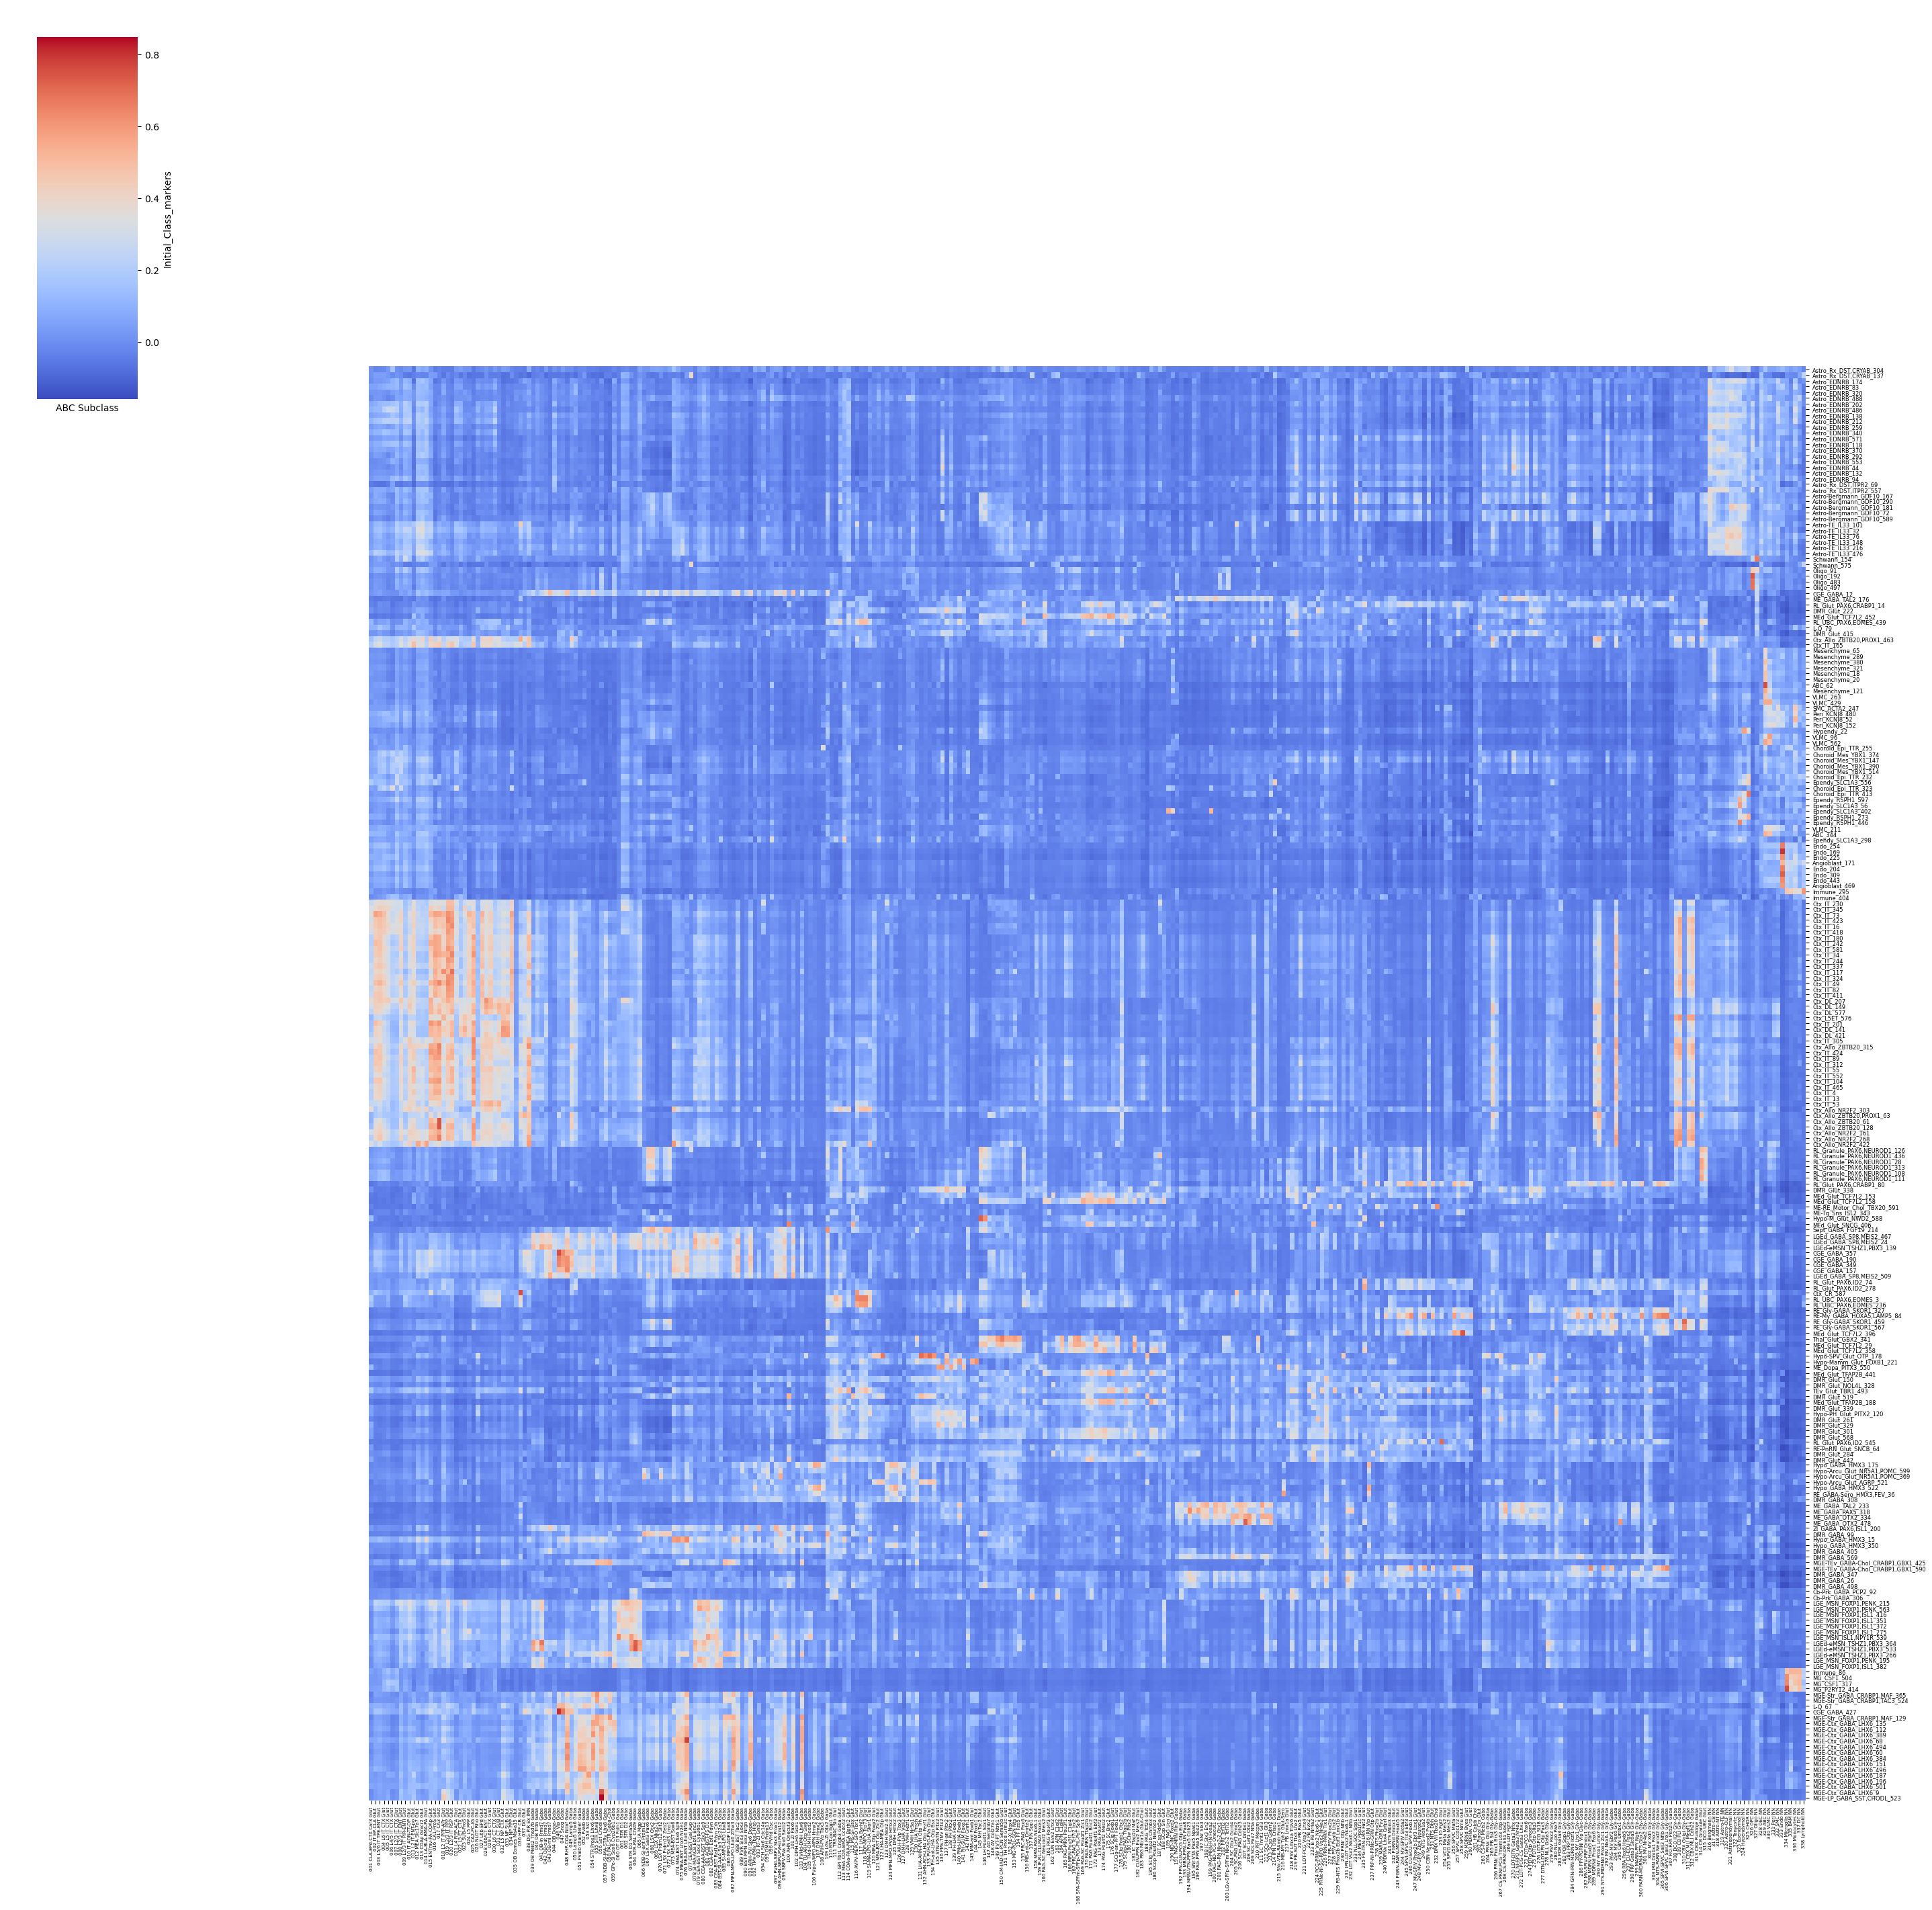

In [40]:
g = seaborn.clustermap(plot_corrs.loc[~plot_corrs.index.str.contains('^NPC|Progen',regex=True)],cmap='coolwarm',figsize=(30,30),xticklabels=True,yticklabels=True,row_cluster=False,col_cluster=False)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 6)
plt.savefig(os.path.join(sc.settings.figdir,'dev_mouse_adult_mouse_corrs.png'))
plt.xlabel('ABC Subclass')
plt.ylabel('Initial_Class_markers')

In [41]:
plot_corrs

001 CLA-EPd-CTX Car3 Glut  002 IT EP-CLA Glut  \
Astro_Rx_DST,CRYAB_304                      0.012429           -0.021142   
Astro_Rx_DST,CRYAB_137                      0.018199            0.044171   
Astro_EDNRB_174                             0.001857            0.030231   
Astro_EDNRB_83                              0.053134            0.055600   
Astro_EDNRB_320                             0.022100            0.019152   
...                                              ...                 ...   
MGE-Ctx_GABA_LHX6_187                       0.042233            0.028310   
MGE-Ctx_GABA_LHX6_196                       0.036514            0.041540   
MGE-Ctx_GABA_LHX6_501                       0.068946            0.056262   
MGE-Ctx_GABA_LHX6_9                        -0.002465            0.040315   
MGE-LP_GABA_SST,CHODL_523                   0.000327            0.038245   

                           003 L5/6 IT TPE-ENT Glut  004 L6 IT CTX Glut  \
Astro_Rx_DST,CRYAB_304                    -0.015237           -0.009925   
Astro_Rx_DST,CRYAB_137                     0.042397            0.044700   
Astro_EDNRB_174                            0.029617            0.040951   
Astro_EDNRB_83                             0.076490            0.095812   
Astro_EDNRB_320                            0.026596            0.018978   
...                                             ...                 ...   
MGE-Ctx_GABA_LHX6_187                      0.052774            0.039305   
MGE-Ctx_GABA_LHX6_196                      0.054169            0.038653   
MGE-Ctx_GABA_LHX6_501                      0.070327            0.049139   
MGE-Ctx_GABA_LHX6_9                        0.066644            0.047966   
MGE-LP_GABA_SST,CHODL_523                  0.056104            0.046383   

                           005 L5 IT CTX Glut  006 L4/5 IT CTX Glut  \
Astro_Rx_DST,CRYAB_304               0.029165              0.158221   
Astro_Rx_DST,CRYAB_137               0.023860             -0.006526   
Astro_EDNRB_174                      0.052619              0.100795   
Astro_EDNRB_83                       0.108839              0.113210   
Astro_EDNRB_320                      0.002978              0.040080   
...                                       ...                   ...   
MGE-Ctx_GABA_LHX6_187                0.088686              0.075645   
MGE-Ctx_GABA_LHX6_196                0.041565              0.033944   
MGE-Ctx_GABA_LHX6_501                0.047064              0.053010   
MGE-Ctx_GABA_LHX6_9                  0.071682             -0.003563   
MGE-LP_GABA_SST,CHODL_523            0.087588              0.006152   

                           007 L2/3 IT CTX Glut  008 L2/3 IT ENT Glut  \
Astro_Rx_DST,CRYAB_304                 0.003395             -0.012406   
Astro_Rx_DST,CRYAB_137                 0.014837             -0.000021   
Astro_EDNRB_174                        0.128679              0.031302   
Astro_EDNRB_83                         0.128887              0.043523   
Astro_EDNRB_320                        0.061194              0.023597   
...                                         ...                   ...   
MGE-Ctx_GABA_LHX6_187                  0.033760              0.157689   
MGE-Ctx_GABA_LHX6_196                  0.037193              0.125830   
MGE-Ctx_GABA_LHX6_501                  0.048614              0.122808   
MGE-Ctx_GABA_LHX6_9                    0.020510              0.169625   
MGE-LP_GABA_SST,CHODL_523              0.023836              0.152982   

                           009 L2/3 IT PIR-ENTl Glut  010 IT AON-TT-DP Glut  \
Astro_Rx_DST,CRYAB_304                      0.018574               0.025117   
Astro_Rx_DST,CRYAB_137                     -0.044897              -0.053570   
Astro_EDNRB_174                             0.122276               0.096654   
Astro_EDNRB_83                              0.148111               0.122054   
Astro_EDNRB_320                             0.085545               0.084235   
...      

In [42]:
plot_corrs_flat = plot_corrs.copy()
idx = plot_corrs.idxmax(0)
for i,j in zip(idx,idx.index):
    plot_corrs_flat.loc[i,j] = np.nan

In [43]:
plot_corrs_flat = pd.DataFrame([['non-max',x] for x in plot_corrs_flat.to_numpy().flatten()] +
             [['max',x] for x in plot_corrs.max(0)],columns=['group','corr'])
plot_corrs_flat = plot_corrs_flat.loc[~plot_corrs_flat['corr'].isna(),:]
plot_corrs_flat

group      corr
0       non-max  0.012429
1       non-max -0.021142
2       non-max -0.015237
3       non-max -0.009925
4       non-max  0.029165
...         ...       ...
128392      max  0.759494
128393      max  0.523773
128394      max  0.520004
128395      max  0.516885
128396      max  0.609057

[128060 rows x 2 columns]

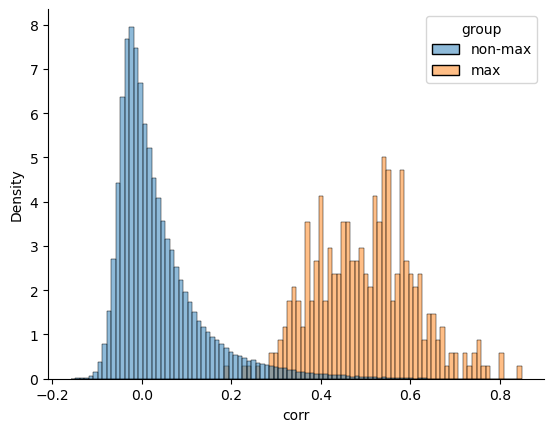

In [44]:
seaborn.histplot(
    data=plot_corrs_flat,
    x="corr",
    hue="group",
    stat="density",      
    common_norm=False,   
    element="bars",      
    multiple="layer",bins=100
)
plt.savefig(os.path.join(sc.settings.figdir,'max_vs_all_map_corrs.svg'))

In [45]:
plausible_corr = 0.3

In [46]:
plot_corrs.loc[~plot_corrs.index.str.contains('^NPC|Progen',regex=True)].max(0).sort_values()[:32]

261 HB Calcb Chol                 0.160804
313 CBX Purkinje Gaba             0.164244
297 CU-ECU Pax2 Gly-Gaba          0.186197
128 VMH Fezf1 Glut                0.236268
159 IF-RL-CLI-PAG Foxa1 Glut      0.257228
158 MRN-PAG Nkx6-1 Glut           0.263283
156 MB-ant-ve Dmrta2 Glut         0.274069
183 PBG Mtnr1a Glut-Chol          0.275128
328 OEC NN                        0.285958
279 PSV Pax2 Gly-Gaba             0.293198
242 PGRNd Dmbx1 Glut              0.298223
165 PAG-MRN Pou3f1 Glut           0.312828
104 TU-ARH Otp Six6 Gaba          0.314161
255 SPVO Mafa Meis2 Glut          0.314713
277 DTN-LDT-IPN Otp Pax3 Gaba     0.319726
283 PRP Otp Gly-Gaba              0.319838
259 MDRNd Bves Glut               0.320279
094 SCH Six6 Cdc14a Gaba          0.323846
241 NTS Mbnl3 Glut                0.328791
269 LDT Fgf7 Gaba                 0.328974
089 PVR Six3 Sox3 Gaba            0.329833
142 HY Gnrh1 Glut                 0.329915
035 OB Eomes Ms4a15 Glut          0.329994
110 BST-po 

In [47]:
plot_corrs.loc[~plot_corrs.index.str.contains('^NPC|Progen',regex=True)].max(1).sort_values()[:32]

Immune_404                  0.184065
Choroid_Mes_YBX1_514        0.239772
Astro_EDNRB_340             0.262216
Choroid_Mes_YBX1_374        0.262416
Choroid_Mes_YBX1_390        0.267603
Astro_Rx_DST,ITPR2_69       0.269484
Astro_EDNRB_94              0.295827
Astro_EDNRB_553             0.296415
ME-Tg_Sns_ISL2_343          0.315945
Choroid_Epi_TTR_255         0.317605
Astro_EDNRB_212             0.325218
Choroid_Mes_YBX1_147        0.327525
Astro_EDNRB_118             0.328148
Astro_EDNRB_174             0.332747
Astro_EDNRB_486             0.333573
Astro_EDNRB_488             0.343428
Astro_EDNRB_292             0.344413
Astro-Bergmann_GDF10_589    0.344994
Astro_EDNRB_202             0.346032
Astro-Bergmann_GDF10_72     0.348813
Astro_Rx_DST,CRYAB_304      0.352833
Astro_EDNRB_83              0.354738
Astro-Bergmann_GDF10_167    0.360423
Mesenchyme_289              0.361044
RE-PnRN_Glut_SNCB_64        0.363390
DMR_Glut_NOL4L_328          0.364212
Choroid_Epi_TTR_323         0.365356
D

In [48]:
neigh_l2.loc[~neigh_l2['Neighborhood'].isin(['Neighbor']),'Initial_Class_markers_level_2']

2              NPC_PEv_DLX2_2
422        Ctx_Allo_NR2F2_422
161        Ctx_Allo_NR2F2_161
61         Ctx_Allo_ZBTB20_61
141                Ctx_DL_141
                ...          
69      Astro_Rx_DST,ITPR2_69
298         Ependy_SLC1A3_298
304    Astro_Rx_DST,CRYAB_304
137    Astro_Rx_DST,CRYAB_137
70                     NPC_70
Name: Initial_Class_markers_level_2, Length: 361, dtype: category
Categories (380, object): ['Astro_Rx_DST,CRYAB_304', 'Astro_Rx_DST,CRYAB_137', 'Astro_EDNRB_174', 'Astro_EDNRB_83', ..., 'MGE-Ctx_GABA_LHX6_196', 'MGE-Ctx_GABA_LHX6_501', 'MGE-Ctx_GABA_LHX6_9', 'MGE-LP_GABA_SST,CHODL_523']

In [49]:
list(plot_corrs.loc[~plot_corrs.index.str.contains('^NPC|Progen',regex=True)].columns[(plot_corrs > plausible_corr).sum(0) == 0])

['128 VMH Fezf1 Glut',
 '158 MRN-PAG Nkx6-1 Glut',
 '183 PBG Mtnr1a Glut-Chol',
 '242 PGRNd Dmbx1 Glut',
 '261 HB Calcb Chol',
 '279 PSV Pax2 Gly-Gaba',
 '297 CU-ECU Pax2 Gly-Gaba',
 '328 OEC NN']

In [50]:
marker_corr_dict=corrs.idxmax(1).to_dict()

In [51]:
adata.obs['abc_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)

/scratch/fast/1984395/ipykernel_2065147/966325606.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['abc_subclass_markercor']=adata.obs[leaf_key].replace(marker_corr_dict)


In [52]:
adata.obs['abc_subclass_markercor'] = adata.obs['abc_subclass_markercor'].cat.reorder_categories(sorted(adata.obs['abc_subclass_markercor'].cat.categories))
# sc_analysis.create_heatmap(sc_analysis.get_cross_category_jaccard(adata.obs,'abc_subclass_markercor',leaf_key),cmap='Purples')
# plt.savefig(os.path.join(sc.settings.figdir,'dev_abc_jaccards.svg'))

In [53]:
dev_mouse_means.to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/dev_mouse_means.csv')
abc_subclass_means.to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/abc_mouse_means.csv')

In [54]:
gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
tf_genes=pd.read_csv(os.path.join(gl_path,'TFs_lambert_pmid29425488_1.01.txt'),sep='\t')
all_tfs=tf_genes['hgnc_symbol']
all_tfs = all_tfs[all_tfs.isin(dev_mouse_means.columns)]

In [55]:
bin_thresh = (binaryness(dev_mouse_means.loc[:,all_tfs],0)>0.85) | (binaryness(abc_subclass_means.loc[:,all_tfs],0)>0.85)
print(bin_thresh.sum())
bin_var_genes = all_tfs[bin_thresh]

772


In [56]:
bin_var_genes = list(set(list(bin_var_genes)+list(include_genes)))

Text(0, 0.5, 'adult var')

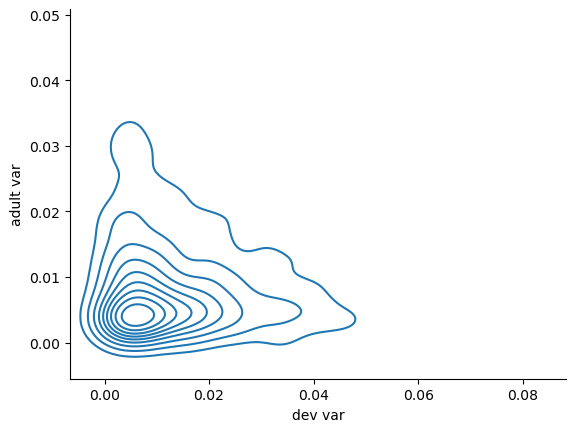

In [57]:
seaborn.kdeplot(x=dev_mouse_means.loc[:,bin_var_genes].var(0),y=abc_subclass_means.loc[:,bin_var_genes].var(0))
plt.xlabel('dev var')
plt.ylabel('adult var')

In [58]:
var_thresh = (dev_mouse_means.loc[:,bin_var_genes].var(0)>0.01) | (abc_subclass_means.loc[:,bin_var_genes].var(0)>0.01)
print(var_thresh.sum())
bin_var_genes = dev_mouse_means.columns[dev_mouse_means.columns.isin(var_thresh.index[var_thresh])]

426


<Axes: >

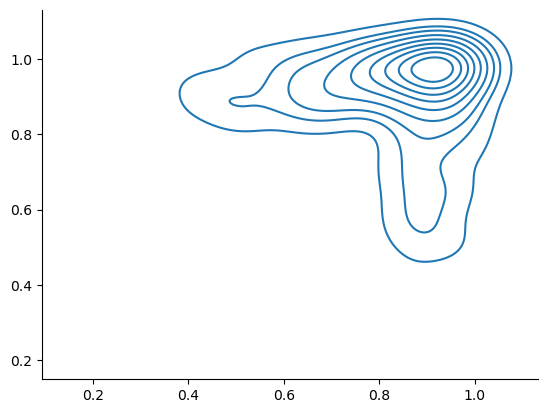

In [59]:
seaborn.kdeplot(x=binaryness(dev_mouse_means.loc[:,bin_var_genes],0),y=binaryness(abc_subclass_means.loc[:,bin_var_genes],0))


In [60]:
print(pd.Series(binaryness(dev_mouse_means.loc[:,include_genes],0),index=include_genes).sort_values())
print(pd.Series(binaryness(abc_subclass_means.loc[:,include_genes],0),index=include_genes).sort_values())

CARHSP1    0.540374
KLF10      0.614921
NR2F1      0.652950
TOX3       0.662624
SOX2       0.685167
             ...   
IRF8       0.988975
IRF5       0.989776
OSR1       0.990094
TBX20      0.992099
SPDEF      0.996135
Length: 255, dtype: float64
SETDB2    0.853993
NR2F1     0.881103
POU3F3    0.881531
ERF       0.888187
NFIX      0.900357
            ...   
FEV       0.999905
OLIG3     0.999927
SOX17     0.999978
CRX       0.999998
TULP1     0.999998
Length: 255, dtype: float64


In [65]:
marker_corr_dict=plot_corrs.idxmax(1).to_dict()

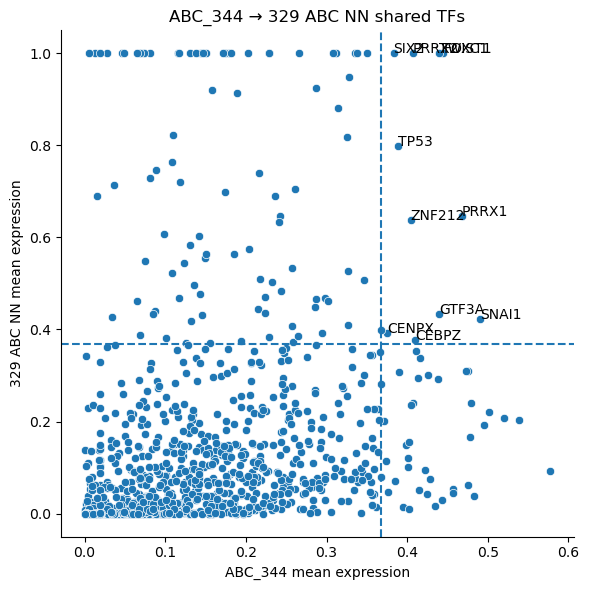

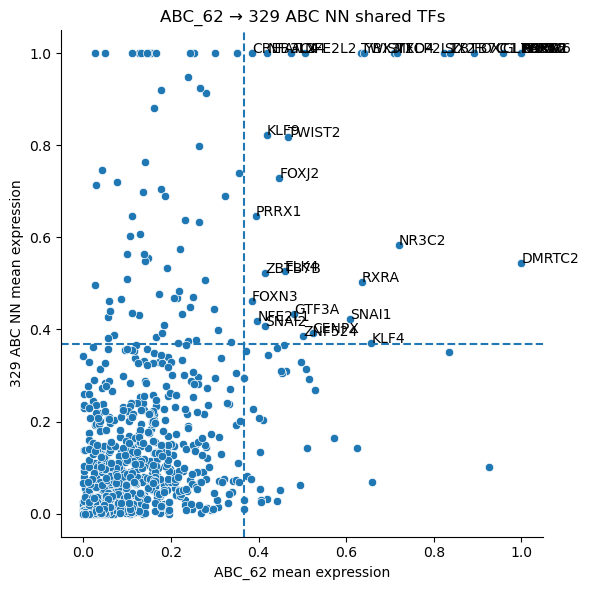

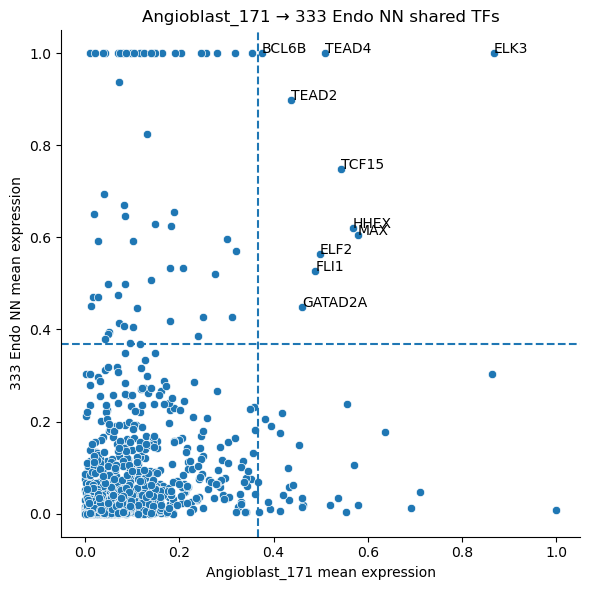

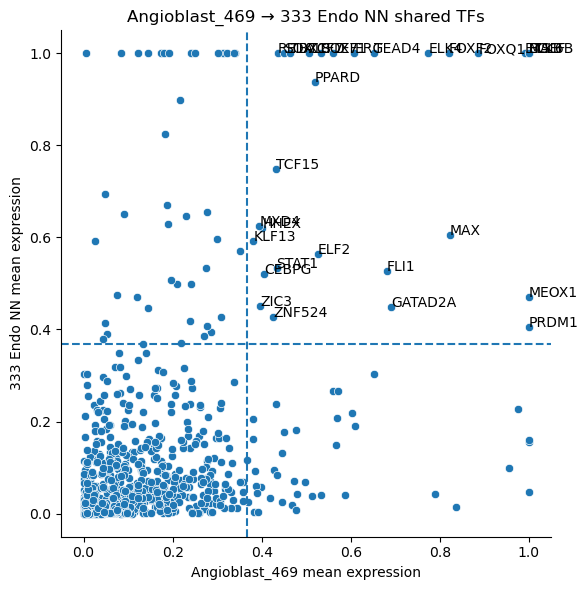

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ef3c194d4e0> (for post_execute), with arguments args (),kwargs {}:


Traceback (most recent call last):
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/events.py", line 82, in trigger
    func(*args, **kwargs)
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/matplotlib_inline/backend_inline.py", line 126, in flush_figures
    return show(True)
           ^^^^^^^^^^
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/display_functions.py", line 298, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPyt

KeyboardInterrupt: 

In [84]:
genes = all_tfs
genes_dev   = set(all_tfs).intersection(plot_dev_mouse_means.columns)
genes_adult = set(all_tfs).intersection(abc_subclass_means.columns)
genes = sorted(genes_dev.intersection(genes_adult))

missing = set(all_tfs) - set(genes)
if missing:
    print(f"Warning: {len(missing)} genes not found and will be skipped:\n", missing)

# 2) now safely index
scores = pd.DataFrame(index=plot_dev_mouse_means.index, columns=genes, dtype=float)

for dev in plot_dev_mouse_means.index:
    adult = marker_corr_dict[dev]
    dev_vals   = plot_dev_mouse_means.loc[dev,   genes]
    adult_vals = abc_subclass_means.loc[adult, genes]
    scores.loc[dev] = np.minimum(dev_vals.values, adult_vals.values)


scores = pd.DataFrame(index=plot_dev_mouse_means.index, columns=genes, dtype=float)
for dev in plot_dev_mouse_means.index:
    adult = marker_corr_dict[dev]
    dev_vals   = plot_dev_mouse_means.loc[dev,   genes]
    adult_vals = abc_subclass_means.loc[adult, genes]
    scores.loc[dev] = np.minimum(dev_vals.values, adult_vals.values)

# 2) Threshold
threshold = 1/np.e
shared_TFs  = {dev: list(scores.loc[dev][scores.loc[dev]>threshold].sort_values().index)
               for dev in scores.index}

# 3) Scatter plots for each dev cluster
for dev in sorted(scores.index):
    adult = marker_corr_dict[dev]
    df_plot = pd.DataFrame({
        'dev_expr':   plot_dev_mouse_means.loc[dev,   genes],
        'adult_expr': abc_subclass_means.loc[adult, genes]
    }, index=genes)

    fig, ax = plt.subplots(figsize=(6,6))
    seaborn.scatterplot(x=df_plot['dev_expr'],
                        y=df_plot['adult_expr'],
                        ax=ax)
    ax.axvline(threshold, linestyle='--')
    ax.axhline(threshold, linestyle='--')
    for gene in shared_TFs[dev]:
        x, y = df_plot.loc[gene]
        ax.text(x, y, gene)
    ax.set_xlabel(f'{dev} mean expression')
    ax.set_ylabel(f'{adult} mean expression')
    ax.set_title(f'{dev} → {adult} shared TFs')
    plt.tight_layout()
    plt.savefig(os.path.join(sc.settings.figdir,''tfscatter',f'tfscatter_{"".join(x for x in dev if x.isalnum())}_{"".join(x for x in adult if x.isalnum())}.png'))
    plt.show()



<Axes: xlabel='None', ylabel='None'>

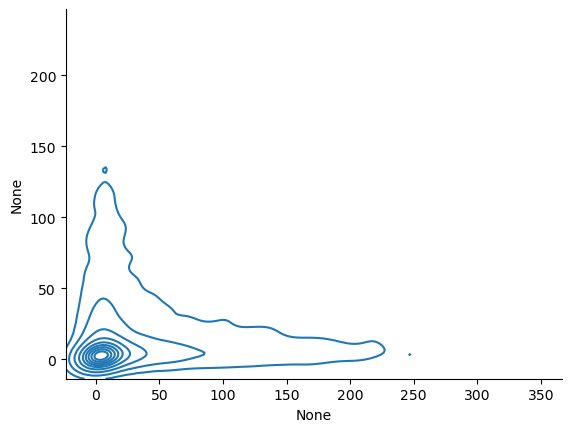

In [71]:
seaborn.kdeplot(x=(dev_mouse_means>0.5).sum(0),y=(abc_subclass_means>0.5).sum(0))

<Axes: xlabel='None', ylabel='None'>

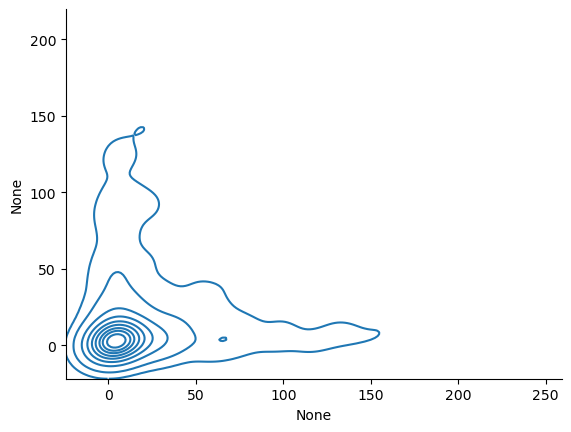

In [72]:
seaborn.kdeplot(x=(dev_mouse_means>0.5).sum(0)[genes],y=(abc_subclass_means>0.5).sum(0)[genes])


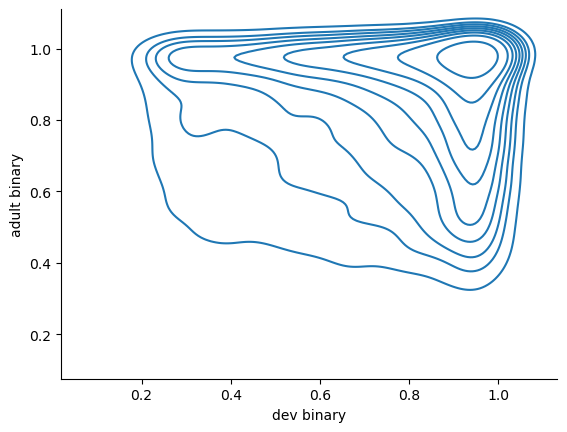

In [73]:
seaborn.kdeplot(x=binaryness(dev_mouse_means,0),y=binaryness(abc_subclass_means,0))
plt.xlabel('dev binary')
plt.ylabel('adult binary')
plt.savefig(os.path.join(sc.settings.figdir,'binaryness_kdeplot.svg'))

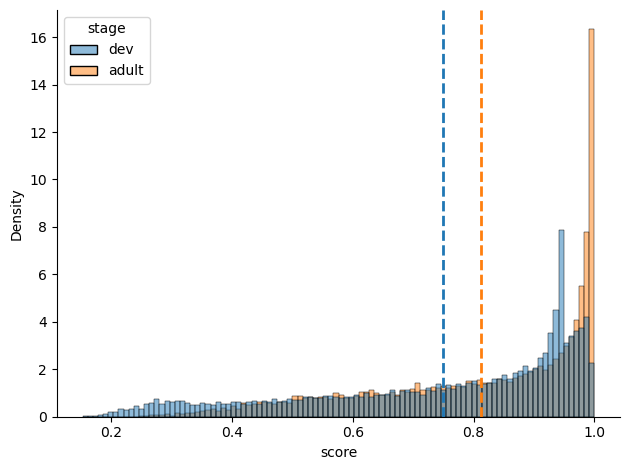

In [74]:
plot_scores = pd.DataFrame(
    [['dev', x] for x in binaryness(dev_mouse_means, 0)] +
    [['adult', x] for x in binaryness(abc_subclass_means, 0)],
    columns=['stage', 'score']
)

means = plot_scores.groupby('stage')['score'].mean()

stages = plot_scores['stage'].unique()
palette = seaborn.color_palette(n_colors=len(stages))
palette_dict = dict(zip(stages, palette))

ax = seaborn.histplot(
    data=plot_scores,
    x="score",
    hue="stage",
    stat="density",
    common_norm=False,
    element="bars",
    multiple="layer",
    bins=100,
    palette=palette_dict
)

for stage, col in palette_dict.items():
    ax.axvline(
        means[stage],
        color=col,
        linestyle='--',
        linewidth=2,
    )


plt.tight_layout()
plt.savefig(os.path.join(sc.settings.figdir,'binaryness_hist.svg'))

In [86]:
neigh_l2

Neighborhood level_2 Initial_Class_markers_level_2
2              P       2                NPC_PEv_DLX2_2
422            T     422            Ctx_Allo_NR2F2_422
161            T     161            Ctx_Allo_NR2F2_161
211     Neighbor     211                      VLMC_211
61             T      61            Ctx_Allo_ZBTB20_61
..           ...     ...                           ...
298           NN     298             Ependy_SLC1A3_298
304           NN     304        Astro_Rx_DST,CRYAB_304
137           NN     137        Astro_Rx_DST,CRYAB_137
575     Neighbor     575                   Schwann_575
70             P      70                        NPC_70

[380 rows x 3 columns]

In [90]:
shared_TFs = {k:v for k,v in shared_TFs.items() if (k==neigh_l2['Initial_Class_markers_level_2'][~neigh_l2['Neighborhood'].isin(['Neighbor'])]).sum()>0}

In [91]:
neuron_tfs = {k:v for k,v in shared_TFs.items() if (k==neigh_l2['Initial_Class_markers_level_2'][neigh_l2['Neighborhood'].isin(['DMR','T'])]).sum()>0}

In [92]:
len(set([x for sublist in shared_TFs.values() for x in sublist]))

617

In [93]:
len(set([x for sublist in neuron_tfs.values() for x in sublist]))

371

In [94]:
pd.DataFrame([[k,','.join(v)] for k,v in shared_TFs.items()],columns=['level_2','tfs']).to_csv('/home/matthew.schmitz/Matthew/data/taxtest/gene_lists/dev_adult_shared_tfs.tsv',sep='\t')


In [95]:
pd.DataFrame([[k,','.join(v)] for k,v in neuron_tfs.items()],columns=['level_2','tfs']).to_csv('/home/matthew.schmitz/Matthew/data/taxtest/gene_lists/dev_adult_shared_neuron_tfs.tsv',sep='\t')

<Axes: ylabel='Proportion'>

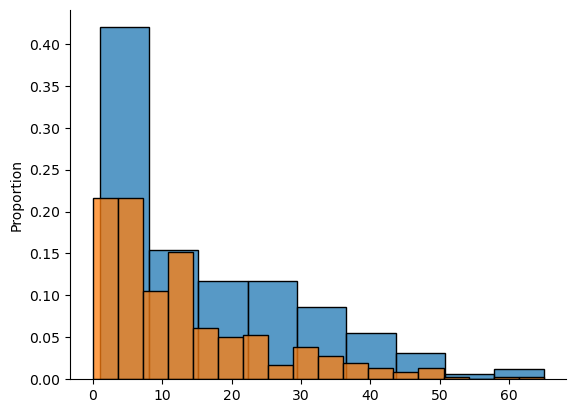

In [96]:
seaborn.histplot([len(x) for x in neuron_tfs.values()],stat='proportion')
seaborn.histplot([len(x) for x in shared_TFs.values()],stat='proportion')

In [97]:
pd.DataFrame([[k,','.join(v)] for k,v in neuron_tfs.items()],columns=['level_2','tfs'])

level_2  \
0                  CGE_GABA_12   
1             ME_GABA_TAL2_176   
2       RL_Glut_PAX6,CRABP1_14   
3                 DMR_Glut_222   
4          MEd_Glut_TCF7L2_452   
..                         ...   
157      MGE-Ctx_GABA_LHX6_187   
158      MGE-Ctx_GABA_LHX6_196   
159      MGE-Ctx_GABA_LHX6_501   
160        MGE-Ctx_GABA_LHX6_9   
161  MGE-LP_GABA_SST,CHODL_523   

                                                   tfs  
0                                              ARX,SP8  
1    ZFP62,ZNF668,ZBTB14,ZNF35,KIN,ZNF532,ZNF451,ZF...  
2    ZFP28,ZNF821,FLYWCH1,GLYR1,KDM5B,ZNF830,MTF2,G...  
3        ZNF263,KDM5B,GLYR1,ZNF408,ZNF830,HIC2,FLYWCH1  
4         ZFP2,ZNF644,CAMTA1,HIC2,BARHL2,GPBP1,FLYWCH1  
..                                                 ...  
157                  GTF3A,THRA,ZNF706,MAX,ARNT2,SATB1  
158       GTF3A,ZNF408,THRA,ARX,ZNF706,SATB1,MAX,ARNT2  
159  ATF2,ZBTB38,MYT1L,MAFG,ZFP2,GZF1,GLYR1,PURG,ME...  
160  SP9,ZNF830,HIC2,CSRNP3,ZNF408,ATF2,ZNF428,BCL1...  
161  ZNF830,ZNF408,KLF5,ATF2,ZNF428,BCL11A,CENPT,LH...  

[162 rows x 2 columns]